#**Investigation of *items* database and correlations between items**

**EDA, NLP, Feature Generation**

Andreas Theodoulou and Michael Gaidis (May, 2020)

#Some Summaries of the Code Below

##**summary of Version 6 plans, modifications, May 30, 2020:**

1. Start by moving more code into functions so it is easier to control everything with parameters from just one or two code windows, and don't need to re-run many cells each time wanting to try something different.
2  Implement application of optional min/max or standard scaling before doing correlation calculations, and implement simple dot product "correlation" method alongside pearson/kendall/spearman
3. Somehow punish shops with zero sales in a given time period when correlating with shops that have substantial non-zero sales in these time periods (maybe scaling sales to a mean of zero will do this??)

##**summary of Version 6 additions, May 29, 2020:**

1. Instead of NLP, go back to looking at correlations in numbers of sales by (shops, items, item categories,...) over time periods (weeks, months, quarters, seasons)

Plans:
1. Consider combining two (or more) different correlation functions, as pearson/kendall/spearman don't always highlight the same... sometimes with good reason, sometimes with poor correlation computation method
2. Also utilize pandas function to simply compute the correlation of an element's sales with same element, or other element, but lagged by n weeks, moonths, quarters... see what things serve as best predictors for another's things (can be item category vs. same item category, lagged by n weeks; can be item sales vs. item category sales lagged by n months; item category sales vs lagged shop sales or vice-versa)
3. Look at creating artificial feature interaction categories, such as shop sales being correlated with item category sales (perhaps lagged)
4. Consider scaling (min/max or perhaps standard) before computing correlation.  This would also allow simple use of dot product to serve as a correlation measure.  Could store the scaling parameters, and apply them to the shop-item pair sales and/or sales by (shop, item, category, etc.) when doing the grouping on the final training set prep, and then apply a reverse transformation to the final prediction.

##**summary of Version 3 additions, May 25, 2020:**

1. Try to reduce the number of clusters to something closer to 250 instead of 2000+... (doing this after reading that decision trees don't like to have to many categories within a single feature)

##**summary of Version 2, May 9, 2020:**

I refined the "delimiter" characters, and did a bit more cleaning on some stuff I noticed with "blu-ray" vs. "bluray" vs. "bd"...
--> generated a new set of unique n-grams for n=1 to highest n, and filtered to include only where there are at least 2 item names containing that n-gram

--> created "word vector" representations of the item names in items dataset, including roughly 4000 elements (all of the delimited n-grams mentioned above)

--> for each of the 21700 items, they were encoded as word vectors, and then I used dot-product to identify which items were similar to others.  In the encoding of the word vectors, I did some "weighting" such that I didn't just have a word vector that was all 0's except for 1's in locations representing the particular n-grams that are found in the item name string (English translation).  I used 2 types of weighting: 
1. like TF-IDF, I counted the number of occurrences of each of the roughly 4000 n-grams in the set of all item names, and I binned the n-grams to more heavily weight n-grams that have less representation in the item names. (For example, "klompferstietnitz" is more valuable than "dvd", because so many item names contain "dvd".  So, the former 1-gram gets a larger integer inserted into its location in the word vector.)  I used binning rather than strict TF-IDF "continuous" weighting because I believe there is a cutoff at which a term no longer holds much weight at all.
2. longer n-grams get heavier weight as well... if two item names have the same 10-word string (10-gram), it is much more relevant than if they have the same 1-word string (1-gram).

--> after running the dot products between items in the 21700 x 4000 size matrix containing word vectors for each item, I end up with a 21700 x 21700 matrix containing integers = dot products of the word vectors i,j for cell at i,j coming from item i and item j.

--> then, I found a nifty jit-accelerated function (reference below) to pick out the top K largest dot-product values for a given item.  The function gives me the top K items and their dot-product values with the item of interest.  I run this function on all 21700 items, and pick (at first the top 3, but now...) the top 10 highest dot-product values for a given item.

**To date** I have only then taken the 5100 items that we know are in the test set (I was afraid of overwhelming the computing power or memory allocation in Colab).  
--> so, now I have a dataset with 5100 rows (each test item), and columns for the top-10 matching item ids as per the dot product, and for the actual top-10 dot products also.

--> I "explode" (unravel) the list of 10 matching items and dot product values so now I have 51000 rows and columns indicating item id of interest (one of the 5100 in the test set), the top-10 matching item ids, and a column for the dot product values between the two.

**Now we need to create features from this**

**First, look for clusters of tightly-matched item-item pairs**

I decided to use the networkX package to map these item pairs into an undirected graph with nodes = item ids, and edges weighted by the value of the dot product.  Then, I can utilize some of the pre-made algorithms that can automatically identify strongly-clustered groups.

Before feeding the 51000 row matrix into the graph, I applied a threshold so only dot products above a certain value would be allowed as nodes/edges in the graph.  (This is to filter out "matches" where both items have some common term like "dvd" but nothing else.  But, as some of the item names are short an nondescriptive, even this "dvd" match can place the item-item pair in the top 10.  Of course, you could have 1000 items like this that match the subject item with the same dot-product value, but the aforementioned algorithm just picks the first 10.)

Ok, so it goes into the graph, and I apply a "community" algorithm that takes into account the weighted edge values (preferentially grouping together items that have higher dot-product values).
I didn't find a way to get much control over how many clusters are identified by the algorithm.  It seems to go up roughly linearly in the number of nodes(items) in the graph.  Anyhow, I get about 1400 clusters for my 5100 input items.  These clusters contain item_ids both in and not in the test set, as the graph was made with 51000 edges (minus about 10000 from thresholding) that used top-10 matches with the 5100 test items.  These top-10 matches may or may not be in the test set.

These 1400 clusters have anywhere from 2 items (one edge) to perhaps 100 items.  I computed an average dot product value between all elements in a cluster, and used that to estimate the overall "strength" of clustering.  This provides a natural way to do category encoding.  I simply use the integer average of cluster dot-products as the "cluster category code".  (One minor complication is that some clusters have identical averages... I gave a small boost to the clusters with greater number of elements, so n=2, avg=300 might get a category value of 300, whereas n=5 avg=300 might get category value = 320)

I assign all items in a given cluster the same "cluster category code".

Any items that do not belong to a cluster (either because they didn't make the top-10 list for any of the test item matches, or because the thresholding eliminated them from inclusion in the graph) were assigned a "cluster category code" equal to their original item_category_code.  The cluster category code is a minimum of 2x or 3x larger than the largest original item category code (83), and the cluster category code can be quite a bit larger ... 100x or more, for the strongest-matching clusters.

</br>

**This was all done with the v1.1 items EDA ipynb on GitHub, and the dataset containing the "cluster category codes" is saved as csv.gz in the data_output directory.  You can just load in that dataset and use the cluster category code column (alongside the item_id column) as a feature in the model.  It shouldn't need further category encoding.**

I'm now working on v2.0 of this items EDA (this file), to remove unnecessary code stragglers, and I hope to try a graph/clustering with all 21700 items rather than just the 5100 test items.



#0. Configure Environment
**NOT OPTIONAL**

In [56]:
# python libraries/modules used throughout this notebook (with some holdovers from other, similar notebooks)
'''
NOTE: selecting a group of code lines and pressing ctrl-/ will toggle commenting of the code lines, for fast and easy disabling/enabling of stuff
'''

# pandas data(database) storage, EDA, and manipulation
import pandas as pd
### pandas formatting
### Adjust as per your preferences.  Here's what I find works well when using a FHD monitor with a full-screen browser window containing my IPynb notebook:
# pd.set_option("display.max_rows",100)     # Override pandas choice of how many rows to show, so we can see the full 84-row item_category df instead of '...' in the middle
# pd.set_option("display.max_columns",30)   # Similar to row code above, we can show more columns than default
# pd.set_option("display.width", 250)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
# pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
### Here's what I find works well for this particular IPynb, when using a FHD laptop monitor with a full-screen browser window containing my IPynb notebook:
pd.set_option("display.max_rows",120)     # Override pandas choice of how many rows to show, so, for example, we can see the full 84-row item_category dataframe instead of the first few rows, then ...., then the last few rows
pd.set_option("display.max_columns",26)   # Similar to row code above, we can show more columns than default  
pd.set_option("display.width", 230)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle

# pd.set_option("display.precision", 3)  # Nah, this is helpful, but below is even better
# Try to convince pandas to print without decimal places if a number is actually an integer (helps keep column width down, and highlights data types), or with precision = 3 decimals if a float
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

# Pandas additional enhancements
pd.set_option('compute.use_bottleneck', False)  # speed up operation when using NaNs
pd.set_option('compute.use_numexpr', False)     # speed up boolean operations, large dataframes; DataFrame.query() and pandas.eval() will evaluate the subexpressions that can be evaluated by numexpr


# data visualization
import matplotlib.pyplot as plt
# ipynb magic command to allow interactive matplotlib graphics in ipynb notebook
%matplotlib inline  
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from IPython.display import Javascript   #used to properly code the creation of sns heatmaps in IPynb with Google Colab
import seaborn as sns

# computations
import numpy as np
from scipy import sparse
from numba import jit, prange  # speedup for appropriate functions and datatypes (no sets, lists, dictionaries, string functions; use np arrays rather than pandas series or dataframes)
#  If you want Numba to throw an error if it cannot compile a function in a way that speeds up your code, pass the argument nopython=True (e.g. @jit(nopython=True))
from numba import vectorize  # speed up row-wise operations like .apply() --> https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html
# can also do np.vectorize (see pandas 1.0.3 documentation section on enhancing speed of pandas operations)

# file operations
import os
import feather   # this is 3x to 8x faster than pd.read_csv and pd.to_hdf, but file size is 2x hdf and 10x csv.gz
import pickle
import json
from urllib.parse import urlunparse
from pathlib import Path

# misc. python enhancements
# note: for a quick look at what's available for magic commands in this ipynb, enter this into a code cell: '%quickref'
import re
import string
from itertools import product
from collections import OrderedDict
import time
import datetime
from time import sleep, localtime, strftime, tzset, strptime
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()


# Specialized packages
# -- for network analysis / graphs / clustering (a reasonable alternative to pca, tSNE, or Knn clustering when number of dimensions is huge)
import networkx as nx
from networkx.algorithms import community, cluster
# -- NLP packages ... for now, as of 5/29/20, only using the lemmatizer, due to the 
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

# ML packages
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# !pip install catboost
# from catboost import CatBoostRegressor
# %tensorflow_version 2.x
# import tensorflow as tf
# import keras as K

# # List of the modules we need to version-track for reference
modules = ['pandas','matplotlib','numpy','scipy','numba','seaborn','sklearn','tensorflow','keras','catboost','pip','nltk','networkx']
print(f'done: {strftime("%a %X %x")}')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
done: Sun 09:00:22 05/31/20


In [0]:
# Some useful things to keep in mind about pandas, Google Colab, and GitHub
# 1) For faster calculations, try using df.query('colxxx > 10') instead of df[df.colxxx > 10]
#     similarly, use eval('sqrt(x)') instead of apply(sqrt(x))... (eval won't work seamlessly with lists, tuples, sets, dictionaries and related commands and iterables)

# 2) When doing apply on a df and you wish to access values from more than one column, be sure to add "axis=1" like so:
#     df.colyyy = df.apply(lambda row: row.colxxx * sqrt(row.colzzz), axis=1)

# 3) If you have a df column that contains lists of items, and you want to create new rows so you have just one of the list items per row (like a cartesian product), use 'explode':
#     e.g, for df containing colxxx = pd.Series([[1,2,3],[0],[],'b a n a n a'.split()])
#     df = df.explode('colxxx')  will transform colxxx to pd.Series([1,2,3,0,NaN(?maybe?),'b','a','n','a','n','a']) and copy the other column values associated with the original series element into each exploded component row

# 4) Set default figure size for matplotlib, seaborn, pandas
#     plt.rcParams["figure.figsize"] = [20,20]

# 5) Heatmap plotting:
#     display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
#     h = sns.heatmap(corr_matrix_cat0,
#                     cmap= sns.color_palette("RdBu_r", 11),   # some other options:  sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
#                     annot=False, #True,  # Turns on/off the labeling of values for each square in the heatmap (set to False if squares are tiny)
#                     fmt= '.0g', #".1g", #".1f",  # Can be tricky to get the right number of decimal places in your annotation, especially if you want 0-precision integers like 1 instead of 1.0, or 0 instead of 0.0
#                     annot_kws={'size':8},
#                     cbar=True,
#                     cbar_kws={"shrink": 0.7},
#                     square=True)
#     plt.show()

# 6) GitHub won't allow free accounts to store files larger than 100 MB in size (and sends a warning if above 50 MB).  So far, the best compression I have found is using csv.gz 
#    If you have files > 100 MB, store them outside your local Colab repo for your own private use, and share with dropbox or some other method
#    Also, it appears that file storage using feather (ftr) is the fastest in terms of file loading (maybe 8x faster than loading csv.gz), but can give filesize 10x that of csv.gz
#    Storage with h5 (hdf) format seems to be in between ftr and csv.gz for speed and file size.  Perhaps the worst of both worlds (or best?).
#    Here is some example code for storage.  Read code is a couple of cells below this one.
#         # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
#         %cd "{OUT_OF_REPO_PATH}"
#         testtrain_mrg.to_feather('testtrain_mrg.ftr')
#         print("testtrain_mrg.ftr feather file stored on google drive, outside repo")
#         %cd "{GDRIVE_REPO_PATH}"
#         # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
#         compression_opts = dict(method='gzip',
#                                 archive_name='testtrain_mrg.csv')  
#         testtrain_mrg.to_csv('data_output/testtrain_mrg.csv.gz', index=False, compression=compression_opts)
#         print("testtrain_mrg.csv.gz file stored on google drive in data_output directory")

# 7) With Colab, when you change runtime type between none(CPU), GPU, and/or TPU, the runtime is reset, and all variables and other local environment storage in RAM is lost
# Therefore, if you decide partway through your notebook that you need the extra power of a GPU, for example, be sure you have set up a simple/quick path to get to this notebook position
# when you change your runtime type.

#0.1) Mount Google Drive (Local File Storage/Repo)

In [58]:
# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive
from google.colab import drive  
drive.mount('/content/drive')
print(f'done: {strftime("%a %X %x")}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
done: Sun 09:00:22 05/31/20


#1. Load Data Files



##1.1) Enter Data File Names and Paths

**NOT Optional**

In [59]:
#  Except for fast-loading (large filesize) feather format files, 
#   the data is coming from a public repo on GitHub at github.com/migai/Kag that has been synced to my local repo on Google Drive

'''
############################################################
############################################################
'''
# Replace this path with the path on *your* Google Drive where the repo master branch is stored
#   (on GitHub, the remote repo is located at github.com/migai/Kag --> below is my cloned repo location)
GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
OUT_OF_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final"   # place > 100MB files here, because they won't sync with GitHub

testtrain_mrg_loaded = False   # set this to True if you plan to load the .ftr or the .csv.gz version of the testtrain_mrg dataframe, and skip the calculations below that generated it
tt_loaded = True
ftr_file_load_employed = True  # set to True if you wish to load the .ftr version or the .csv.gz version... it's faster, but its a 10x larger file, and won't work in the GitHub repo push


# if using large feather file for fast loading, use the routine here
#   note that this is too large to push to GitHub, so if you want to go this route, 
#   you'll first have to load (more slowly) the 'data_output/testtrain_mrg.csv.gz' file 
#   with pandas read_csv, and then store the file as feather type (outside your local GitHub repo)
#   Or, you can just recreate the dataframe by running the first few code cells that do merging and data manipulation
# load feather files manually for now
if (testtrain_mrg_loaded and ftr_file_load_employed):
    print('ftr files source directory: ', end='')
    %cd "{OUT_OF_REPO_PATH}"
    testtrain_mrg = pd.read_feather('testtrain_mrg.ftr', columns=None, use_threads=True)
    print("Loading ftr Files from Google Drive (outside repo) into Colab... \n\nData Frame: testtrain_mrg (from ftr)")
    print(testtrain_mrg.head(2))
if (tt_loaded and ftr_file_load_employed):
    print('ftr files source directory: ', end='')
    %cd "{OUT_OF_REPO_PATH}"
    tt = pd.read_feather('tt.ftr', columns=None, use_threads=True)
    print("Loading ftr Files from Google Drive (outside repo) into Colab... \n\nData Frame: tt (from ftr)")
    print(tt.head(2))

'''
############################################################
############################################################
'''

data_files = []
# List of the data files (path relative to GitHub master), to be loaded into pandas DataFrames
if (testtrain_mrg_loaded and not ftr_file_load_employed):
    data_files = [  "data_output/testtrain_mrg.csv.gz" ]

if (tt_loaded and not ftr_file_load_employed):
    data_files = [  "data_output/tt.csv.gz" ]
                
data_files += [  #"readonly/final_project_data/shops.csv",
                #"readonly/final_project_data/sample_submission.csv.gz",
                #"data_output/shops_transl.csv",
                #"data_output/items_transl.csv",
                #"readonly/final_project_data/item_categories.csv",
                #"data_output/items_clustered_22170.csv.gz",
                #"readonly/en_50k.csv",
                #"data_output/item_categories_transl.csv",
                #"data_output/shops_augmented.csv",
                #"readonly/final_project_data/items.csv",
                #"data_output/sales_train_cleaned.csv.gz",
                #"data_output/items_new.csv",
                #"data_output/shops_new.csv",
                #"readonly/final_project_data/sales_train.csv.gz",
                #"readonly/final_project_data/test.csv.gz",
                "data_output/item_categories_augmented.csv"
                ]


# Dict of helper code files, to be loaded and imported {filepath : import_as}
code_files = {}  # not used at this time; example dict = {"helper_code/kaggle_utils_at_mg.py" : "kag_utils"}


# GitHub file location info
git_hub_url = "https://raw.githubusercontent.com/migai"
repo_name = 'Kag'
branch_name = 'master'
base_url = os.path.join(git_hub_url, repo_name, branch_name)

print(f'done: {strftime("%a %X %x")}')

ftr files source directory: /content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final
Loading ftr Files from Google Drive (outside repo) into Colab... 

Data Frame: tt (from ftr)
   day  day_of_week  day_of_month  week  quarter  season  month  price  sales  shop_id  item_id                                      item_name  it_test  item_category_id   item_category_name  it_cat_test item_cat3 item_cat4  \
0    0            2             1     0        0       2      0     99      1        2      991      3D Action Puzzle "Dinosaur" Tyrannosaurus    False                67  Gifts - Development         True     Gifts     Gifts   
1    0            2             1     0        0       2      0   2599      1        2     1472  Assassin's Creed 3 [Xbox 360 Russian version]    False                23     Games - XBOX 360         True     Games      Xbox   

          shop_name sh_cat  sh_test district    fd_popdens fd_gdp    city  population  
0  Adygea TC "Mega"   Mega     True   

In [60]:
d=['a']
print(d)
d=d+['c','e']
print(d)

['a']
['a', 'c', 'e']


##1.2) Load Data Files

In [61]:
%%time
# 4.5sec with csv and csv.gz files (including conversion to datetime)
# 3.6sec with csv and csv.gz files (no datetime conversion)
if data_files:
    print('\n\ncsv files source directory: ', end='')
    %cd "{GDRIVE_REPO_PATH}"

    print("\nLoading csv Files from Google Drive repo into Colab...\n")

    # Loop to load the data files into appropriately-named pandas DataFrames
    for path_name in data_files:
        filename = path_name.rsplit("/")[-1]
        data_frame_name = filename.split(".")[0]
        exec(data_frame_name + " = pd.read_csv(path_name)")
        # if data_frame_name == 'sales_train':
        #     sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d.%m.%Y')
        print(f'DataFrame {data_frame_name}, shape = {eval(data_frame_name).shape} :')
        print(eval(data_frame_name).head(2))
        print("\n")
else: 
    %cd "{GDRIVE_REPO_PATH}"
    
print(f'done: {strftime("%a %X %x")}')



csv files source directory: /content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag

Loading csv Files from Google Drive repo into Colab...

DataFrame item_categories_augmented, shape = (84, 8) :
        item_category_name  item_category_id                 en_cat_name item_category1 item_category2 item_category3 item_category4  item_cat_tested
0  PC - Гарнитуры/Наушники                 0  PC - Headsets / Headphones          Audio             PC    Accessories             PC             True
1         Аксессуары - PS2                 1           Accessories - PS2    Accessories    PlayStation    Accessories    PlayStation            False


done: Sun 09:00:25 05/31/20
CPU times: user 15.1 ms, sys: 1.6 ms, total: 16.7 ms
Wall time: 297 ms


#2. Explore Data (EDA), Clean Data, and Generate Features

#2.x) ***shops***, ***items***, and ***item_categories*** Datasets: 
EDA, Cleaning, Correlations, and Feature Generation

---



---



##2.x.1) Merge Datasets and create day, week, quarter, and season columns 
(for finer control over time lags)

In [0]:
if not (testtrain_mrg_loaded or tt_loaded):  # we already have this loaded from feather file (1.5sec) or csv.gz (5sec)  (12sec by CPU if redoing these merges)
    # merge dataframes so we can do closer analysis of item dependence on shop and categories
    test_prep = test.copy(deep=True)
    test_prep['date_block_num'] = 34
    test_prep['date'] = '2015-11-30' #pd.Timestamp(year=2015, month=11, day=30)
    sales_traintest_clean_mrg = sales_train_cleaned.append(test_prep).fillna(0)
    testtrain_mrg = sales_traintest_clean_mrg.merge(items_new[['item_id','item_category_id','item_tested']],on='item_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg.merge(items_transl[['item_id','en_item_name']],on='item_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg.merge(item_categories_augmented[['item_category_id','en_cat_name','item_cat_tested','item_category3','item_category4']],on='item_category_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg.merge(shops_augmented[['shop_id', 'en_shop_name', 'shop_city', 'shop_federal_district',  'shop_city_population',  'shop_tested']], on='shop_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg.merge(shops_new[['shop_id', 'shop_type', 'fd_popdens',  'fd_gdp']], on='shop_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg[['date', 'date_block_num', 'item_price', 'item_cnt_day', 'shop_id', 'item_id', 'en_item_name', 'item_tested', 'item_category_id', 'en_cat_name', 'item_cat_tested',
                                'item_category3', 'item_category4', 'en_shop_name', 'shop_type','shop_tested', 'shop_federal_district', 'fd_popdens', 'fd_gdp', 'shop_city', 'shop_city_population']]
    testtrain_mrg.columns = ['date', 'month', 'price', 'sales', 'shop_id', 'item_id', 'item_name', 'it_test', 'item_category_id', 'item_category_name', 'it_cat_test', 'item_cat3', 'item_cat4', 
                            'shop_name', 'sh_cat', 'sh_test', 'district', 'fd_popdens', 'fd_gdp', 'city', 'population']
                    

    #testtrain_mrg.date = testtrain_mrg.date.apply(lambda x: tuple(int(i) for i in x.split("-")) )  # feather data format will not support lists or tuples as dataframe elements; move this below

    # # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
    # %cd "{OUT_OF_REPO_PATH}"
    # testtrain_mrg.to_feather('testtrain_mrg.ftr')
    # print("testtrain_mrg.ftr feather file stored on google drive, outside repo")
    # %cd "{GDRIVE_REPO_PATH}"
    # # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
    # compression_opts = dict(method='gzip',
    #                         archive_name='testtrain_mrg.csv')  
    # testtrain_mrg.to_csv('data_output/testtrain_mrg.csv.gz', index=False, compression=compression_opts)
    # print("testtrain_mrg.csv.gz file stored on google drive in data_output directory")

    print(f'done: {strftime("%a %X %x")}\n')
    #testtrain_mrg.tail(2)

def create_time_columns(string_date_dataframe, day0 = datetime.datetime(2013,1,1)):
    """
    Given a dataframe with a 'date' column containing strings like '2015-10-30', create new time-series columns:
    1. 'day'    = integer value of day number, starting at day = 0 for parameter day0, and incrementing by calendar day number (not by transaction day number)... 
                    Thus, 'day' may not include all possible integers from start to finish.  It only assigns integer values (based on the calendar) to days when 
                    there are transactions in the input dataframe --> if the input dataframe has no transactions on a particular day, that day's 'calendar' integer value will not be present in the column (will be = 0)
                    day_of_week = by name, Sunday, Monday, ...
                    day_of_month = 0-30
    2. 'week'   = integer value of week number, with week = 0 at time= parameter day0.  However, unlike 'day', the 'week' number is aligned not to start at day0, but rather
                    so that there is a full 'week' of 7 days that ends on Oct. 31, 2015 (the final day of training data).  This results in week = 0 having only 5 days in it.
                    n.b., the final week of October, 2015 is assigned 'week' number = 147.  week = 0 includes day0.  artifically assigning test to Nov. 30, 2015 results in test week = 152 (including only Nov 29 and 30)
    3. 'month'  = renamed "date_block_num" from original data set; no changes made.  Integer values from 0 to 33 represent the months starting at day0.  month=34 is Nov. 2015, and is the test month.
    4. 'quarter' = integer number of 3-month chunks of time, aligned with the end of October, 2015.  day0 is included in 'quarter' = 0, but 'quarter'=0 only contains 1 month (Jan 2013) of data due to the alignment
                    The months of August, Sept, Oct 2015 form 'quarter' = 11.  "Quarter" in this sense is just 3-month chunks... it is not the traditional Q1,Q2,Q3,Q4 beginning Jan 1, but instead is more like
                    date_block_num in that it is monotonically increasing integers, incremented every 3 months such that #11 ends at the end of our training data
    5. 'season' = integer number of 3-month chunks of time, reset each year (allowed values = 0,1,2,3)... not quite the same as spring-summer-winter-fall, or Q1,Q2,Q3,Q4, but instead shifted to 
                    better capture seasonal spending trends aligned in particular with high December spending
                    0 = Dec 1 to Feb 28 (biggest spending season), 1 = Mar 1 to May 31, 2 = June 1 to Aug 30 (lowest spending season), 3 = Sept 1 to Nov 30

    Finally, drop the date column from the dataframe, and sort the dataframe by ['day','shop_id','item_id']  (original dataframe seems to be sorted by month, but unsorted within each month)
    """

    tt = string_date_dataframe.copy(deep=True)
    tt.date = tt.date.apply(lambda x: [int(i) for i in x.split("-")] )
    tt.date = tt.date.apply(lambda x: datetime.datetime(x[0],x[1],x[2]))
    tt.insert(1,'day',0)
    tt.insert(2,'day_of_week',0)
    tt.insert(3,'day_of_month',0)
    tt.insert(4,'week',0)
    tt.insert(5,'quarter',0)
    tt.insert(6,'season',0)  
    #tt.date = tt.date.apply(lambda x: [int(i) for i in x.split("-")] )  # substantially faster (3-5x) to go from string to list to datetime, rather than convert string to datetime... this is the slow part (5 sec)
    tt.day = tt.date.apply(lambda x: (x - day0).days)  # 2.5 sec
    tt.day_of_week = tt.date.apply(lambda x: (x.weekday()+1)%7 )  # 0=Sunday, 1=Monday, ... 6= Saturday   # use x.strftime('%A') to get text string day of the week (Sunday, Monday, ...)
    tt.day_of_month = tt.date.apply(lambda x: x.day)
    tt.week = (tt.day+2) // 7           # add the 2 days so we have end of a week coinciding with end of training data Oct. 31, 2015
    tt.quarter = (tt.month + 2) // 3    # add the 2 months so we have end of a quarter aligning with end of training data Oct. 31, 2015
    tt.season = (tt.month + 2) % 4
    tt.drop('date',axis=1,inplace=True)
    tt = tt.sort_values(['day','shop_id','item_id']).reset_index(drop=True)  # note that the train dataset is sorted by month, but nothing obvious within the month; we sort it here for consistent results in calculations below
    print(f'tt dataframe creation done: {strftime("%a %X %x")}\n')
    return tt


In [0]:
if not tt_loaded:
    print(f'tt dataframe creation started: {strftime("%a %X %x")}\n')
    tt = create_time_columns(testtrain_mrg)

    # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
    %cd "{OUT_OF_REPO_PATH}"
    tt.to_feather('tt.ftr')
    print("tt.ftr feather file stored on google drive, outside repo")
    %cd "{GDRIVE_REPO_PATH}"
    # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
    compression_opts = dict(method='gzip',
                            archive_name='tt.csv')  
    tt.to_csv('data_output/tt.csv.gz', index=False, compression=compression_opts)
    print("tt.csv.gz file stored on google drive in data_output directory")
    print(f'tt file save done: {strftime("%a %X %x")}')

In [64]:
tt[tt.week == 102].head()

,day,day_of_week,day_of_month,week,quarter,season,month,price,sales,shop_id,item_id,item_name,it_test,item_category_id,item_category_name,it_cat_test,item_cat3,item_cat4,shop_name,sh_cat,sh_test,district,fd_popdens,fd_gdp,city,population
2209504,712,0,14,102,8,1,23,2199,1,2,1497,Assassin's Creed IV. Black Flag [Xbox 360 Russian version],False,23,Games - XBOX 360,True,Games,Xbox,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055
2209505,712,0,14,102,8,1,23,1609,1,2,1811,"Batman: Arkham Chronicle [PS3, Russian subtitles]",True,19,Games - PS3,True,Games,PlayStation,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055
2209506,712,0,14,102,8,1,23,2899,1,2,2284,"Call of Duty: Advanced Warfare [PS3, Russian version]",True,19,Games - PS3,True,Games,PlayStation,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055
2209507,712,0,14,102,8,1,23,999,1,2,2442,"Crysis 3 (Classics) [Xbox 360, Russian version]",True,23,Games - XBOX 360,True,Games,Xbox,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055
2209508,712,0,14,102,8,1,23,999,1,2,2808,"Diablo III [PC, Jewel, Russian version]",True,30,Games PC - Standard Edition,True,Games,PC,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055


In [65]:

print(tt.shape)
df = tt.groupby(['week']).agg({'month':'mean', 'sales':'sum'})
df.month = df.month*5000 -100000
print(df.shape)
df.head()

(3128468, 26)
(149, 2)


,month,sales
week,,
0,-100000,30304
1,-100000,30920
2,-100000,25806
3,-100000,26495
4,"-98,185.222",26645


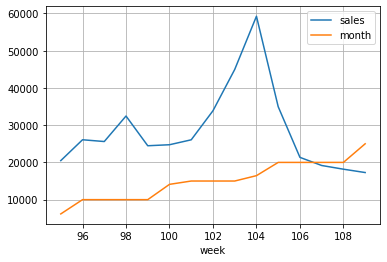

In [66]:
df.iloc[95:110,:].plot(y=['sales','month'],kind='line',grid=True)
# week 100-104 = month 23, week 96 to 99 = month 22, week 105-108 = month 23

(3128468, 26)
(1035, 5)
     month  week  day_of_week  day_of_month  sales
day                                               
285   4500    41            0            13   4917
286   4500    41            1            14   2785
287   4500    41            2            15   2881
288   4500    41            3            16   2821
289   4500    41            4            17   3090
290   4500    41            5            18   3748
291   4500    41            6            19   6017
292   4500    42            0            20   4696
293   4500    42            1            21   2294
294   4500    42            2            22   2246
295   4500    42            3            23   2540
296   4500    42            4            24   2733
297   4500    42            5            25   4381
298   4500    42            6            26   6115
299   4500    43            0            27   4993


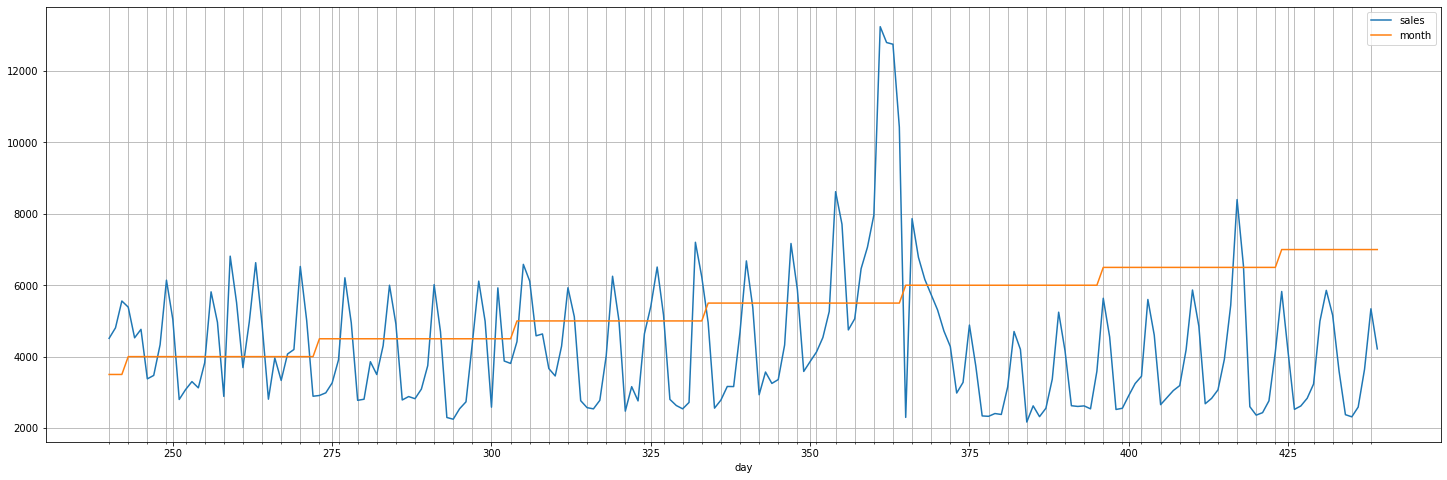

In [67]:

print(tt.shape)
dfd = tt.groupby(['day']).agg({'month':'mean', 'week':'mean', 'day_of_week':'mean','day_of_month':'mean','sales':'sum'})
dfd.month = dfd.month*500
print(dfd.shape)
print(dfd.iloc[285:300,:].head(40))
ax = dfd.iloc[240:440,:].plot(y=['sales','month'],kind='line',grid=True,figsize=(25,8)) #df.iloc[95:110,:]
ax.set_xticks( list(range(240,441,3)), minor=True )
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major', axis='x' )

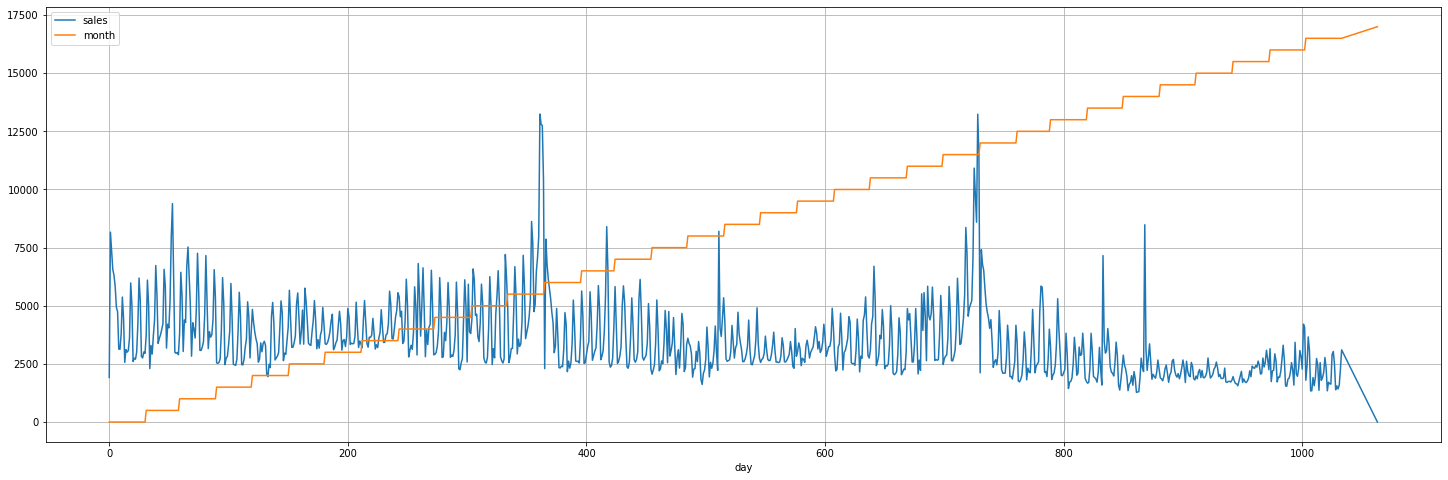

In [68]:

ax = dfd.plot(y=['sales','month'],kind='line',grid=True,figsize=(25,8)) #df.iloc[95:110,:]
ax.set_xticks( list(range(1036,7)), minor=True )
ax.grid('on', which='minor', axis='x' )
ax.grid('on', which='major', axis='x' )

   quarter  day_of_week  sales  mean   std
0        0            0  20552 1.145 0.677
1        0            1  12910 1.101 0.505
2        0            2  15284 1.115 0.594
3        0            3  20018 1.149 0.866
4        0            4  19516 1.120 0.575


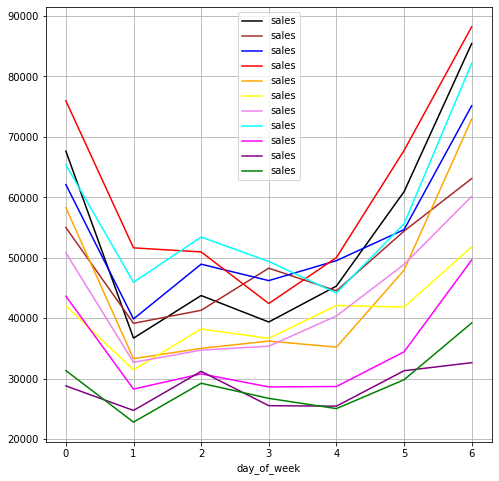

In [69]:

df3 = tt.groupby(['quarter','day_of_week']).agg({'sales':['sum','mean','std']}).reset_index()
df3.columns = ['quarter','day_of_week','sales','mean','std']
print(df3.head())
#df3.plot(y=['sales'],kind='line',grid=True,figsize=(25,8))
#df3.plot.scatter(x=['day_of_week'],y=['sales'],grid=True,figsize=(10,8))
ax = df3[df3.quarter==1].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8),color='black')
df3[df3.quarter==2].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='brown')
df3[df3.quarter==3].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='blue')
df3[df3.quarter==4].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='red')
df3[df3.quarter==5].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='orange')
df3[df3.quarter==6].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='yellow')
df3[df3.quarter==7].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='violet')
df3[df3.quarter==8].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='cyan')
df3[df3.quarter==9].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='magenta')
df3[df3.quarter==10].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='purple')
df3[df3.quarter==11].plot(x='day_of_week',y=['sales'],kind='line',grid=True,figsize=(8,8), ax=ax, color='green')

In [70]:
df4 = tt[tt.month<34].groupby(['month','day_of_week']).agg({'sales':['sum']}).reset_index()
df4.columns = ['month','day_of_week','sales']
print(df4.head())
df4p = df4.pivot(index = 'month', columns = 'day_of_week', values = 'sales').reset_index()
df4p.columns = ['month','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
df4pcols = df4p.columns
print(df4p.head())
print(df4p.shape)
print(df4p.describe())

   month  day_of_week  sales
0      0            0  20552
1      0            1  12910
2      0            2  15284
3      0            3  20018
4      0            4  19516
   month  Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday
0      0   20552   12910    15284      20018     19516   18172     23849
1      1   22431   11860    14060      13715     15839   20356     28793
2      2   26556   12106    15625      15144     17525   25208     33733
3      3   18655   12728    14057      10506     11947   15360     22919
4      4   15629    9941    10384      16483     16123   19907     17398
(34, 8)
       month     Sunday     Monday    Tuesday  Wednesday   Thursday     Friday   Saturday
count     34         34         34         34         34         34         34         34
mean  16.500 17,692.765 11,747.235 13,316.588 12,787.794 13,231.206 16,049.971 21,304.029
std    9.958  5,946.214  4,019.961  4,287.220  3,857.976  3,401.775  4,436.597  6,786.368
min        0       8

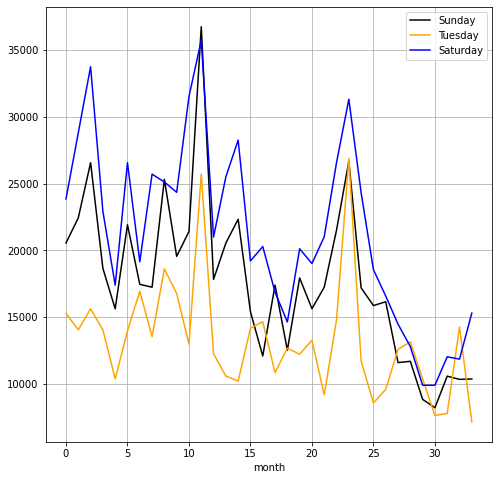

In [71]:

ax = df4p.plot(x='month',y='Sunday',kind='line',grid=True,figsize=(8,8),color='black')
#df4p.plot(x='month',y='Monday',kind='line',grid=True,figsize=(8,8), ax=ax, color='red')
df4p.plot(x='month',y='Tuesday',kind='line',grid=True,figsize=(8,8), ax=ax, color='orange')
#df4p.plot(x='month',y='Wednesday',kind='scatter',grid=True,figsize=(8,8), ax=ax, color='magenta')
#df4p.plot(x='month',y='Thursday',kind='scatter',grid=True,figsize=(8,8), ax=ax, color='cyan')
#df4p.plot(x='month',y='Friday',kind='scatter',grid=True,figsize=(8,8), ax=ax, color='brown')
df4p.plot(x='month',y='Saturday',kind='line',grid=True,figsize=(8,8), ax=ax, color='blue')

In [72]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
for compare_day in days:
    compare_cols = [e for e in df4pcols if e not in ('month', compare_day)]
    new_colnames = [compare_day[:3]+'_'+c[:3] for c in compare_cols]
    for idx in range(len(compare_cols)):
        df4p[new_colnames[idx]] = df4p[compare_day] - df4p[compare_cols[idx]]

print(df4p.shape)
df4p.head()

(34, 50)


,month,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sun_Mon,Sun_Tue,Sun_Wed,Sun_Thu,Sun_Fri,...,Thu_Sat,Fri_Sun,Fri_Mon,Fri_Tue,Fri_Wed,Fri_Thu,Fri_Sat,Sat_Sun,Sat_Mon,Sat_Tue,Sat_Wed,Sat_Thu,Sat_Fri
0,0,20552,12910,15284,20018,19516,18172,23849,7642,5268,534,1036,2380,...,-4333,-2380,5262,2888,-1846,-1344,-5677,3297,10939,8565,3831,4333,5677
1,1,22431,11860,14060,13715,15839,20356,28793,10571,8371,8716,6592,2075,...,-12954,-2075,8496,6296,6641,4517,-8437,6362,16933,14733,15078,12954,8437
2,2,26556,12106,15625,15144,17525,25208,33733,14450,10931,11412,9031,1348,...,-16208,-1348,13102,9583,10064,7683,-8525,7177,21627,18108,18589,16208,8525
3,3,18655,12728,14057,10506,11947,15360,22919,5927,4598,8149,6708,3295,...,-10972,-3295,2632,1303,4854,3413,-7559,4264,10191,8862,12413,10972,7559
4,4,15629,9941,10384,16483,16123,19907,17398,5688,5245,-854,-494,-4278,...,-1275,4278,9966,9523,3424,3784,2509,1769,7457,7014,915,1275,-2509


In [73]:
compare_day = 'Saturday'
color = ['black','red','orange','cyan','blue','purple','brown','pink']
compare_cols = [e for e in df4pcols if e not in ('month', compare_day)]
new_colnames = [compare_day[:3]+'_'+c[:3] for c in compare_cols]
print(f'ax = df4p.plot(x="month",y="{new_colnames[0]}",kind="line",grid=True,figsize=(8,8),color="{color[0]}")')
for i,c in enumerate(new_colnames[1:]):
    print(f'df4p.plot(x="month",y="{c}",kind="line",grid=True,figsize=(8,8),ax=ax,color="{color[i]}")')

ax = df4p.plot(x="month",y="Sat_Sun",kind="line",grid=True,figsize=(8,8),color="black")
df4p.plot(x="month",y="Sat_Mon",kind="line",grid=True,figsize=(8,8),ax=ax,color="black")
df4p.plot(x="month",y="Sat_Tue",kind="line",grid=True,figsize=(8,8),ax=ax,color="red")
df4p.plot(x="month",y="Sat_Wed",kind="line",grid=True,figsize=(8,8),ax=ax,color="orange")
df4p.plot(x="month",y="Sat_Thu",kind="line",grid=True,figsize=(8,8),ax=ax,color="cyan")
df4p.plot(x="month",y="Sat_Fri",kind="line",grid=True,figsize=(8,8),ax=ax,color="blue")


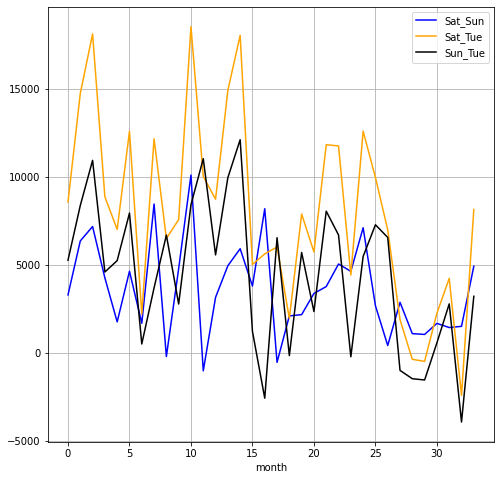

In [74]:
ax = df4p.plot(x="month",y="Sat_Sun",kind="line",grid=True,figsize=(8,8),color="blue")
#df4p.plot(x="month",y="Sat_Mon",kind="line",grid=True,figsize=(8,8),ax=ax,color="black")
df4p.plot(x="month",y="Sat_Tue",kind="line",grid=True,figsize=(8,8),ax=ax,color="orange")
#df4p.plot(x="month",y="Sat_Wed",kind="line",grid=True,figsize=(8,8),ax=ax,color="orange")
#df4p.plot(x="month",y="Sat_Thurs",kind="line",grid=True,figsize=(8,8),ax=ax,color="cyan")
df4p.plot(x="month",y="Sun_Tue",kind="line",grid=True,figsize=(8,8),ax=ax,color="black")

In [75]:
print(df4p[['month','Sat_Sun','Sat_Mon','Sat_Tue','Sat_Wed','Sat_Thu','Sat_Fri']].describe())

       month   Sat_Sun    Sat_Mon   Sat_Tue    Sat_Wed   Sat_Thu   Sat_Fri
count     34        34         34        34         34        34        34
mean  16.500 3,611.265  9,556.794 7,987.441  8,516.235 8,072.824 5,254.059
std    9.958 2,673.220  4,943.037 5,361.676  5,652.712 5,041.086 3,521.776
min        0     -1010        809     -2398         57       206     -2509
25%    8.250 1,685.500       6340      4574  4,074.500 3,937.750 3,254.750
50%   16.500 3,339.500  9,453.500 7,728.500  8,277.500 7,093.500 4,655.500
75%   24.750 4,946.250 12,327.750     11803 12,275.250     11287 7,722.500
max       33     10099      21627     18516      20012     17919     13477


In [76]:
print(df4p[['month','Sat_Sun','Sat_Mon','Sat_Tue','Sat_Wed','Sat_Thu','Sat_Fri']][df4p.month<26].describe())

       month   Sat_Sun    Sat_Mon    Sat_Tue    Sat_Wed    Sat_Thu   Sat_Fri
count     26        26         26         26         26         26        26
mean  12.500 4,144.308 11,049.500  9,664.500  9,956.038  9,309.423 6,073.808
std    7.649 2,759.836  4,451.618  4,654.038  5,514.906  5,005.528 3,499.841
min        0     -1010       3043       1962         57        824     -2509
25%    6.250 2,306.250       8662  6,134.750  5,913.750  5,468.250 3,855.500
50%   12.500 4,032.500      10591       8795  9,573.500  9,358.500 5,732.500
75%   18.750 5,702.250 13,792.500 12,476.750 13,771.750 12,267.250 8,217.500
max       25     10099      21627      18516      20012      17919     13477


In [77]:
print(df4p[['month','Sat_Sun','Sat_Mon','Sat_Tue','Sat_Wed','Sat_Thu','Sat_Fri']][df4p.month>25].describe())

       month   Sat_Sun   Sat_Mon   Sat_Tue   Sat_Wed   Sat_Thu   Sat_Fri
count      8         8         8         8         8         8         8
mean  29.500 1,878.875 4,705.500      2537 3,836.875 4,053.875 2,589.875
std    2.449 1,414.579 3,039.594 3,710.678 3,047.930 2,485.874 2,029.043
min       26       428       809     -2398       235       206      -440
25%   27.750 1,089.750 2,062.250      -385      1553      3059 1,007.250
50%   29.500      1481      4843      2078      3660      3762      2879
75%   31.250 1,982.250 6,517.750 4,923.750      5479 5,974.500      3846
max       33      4923      9873      8143      8524      7247      5542


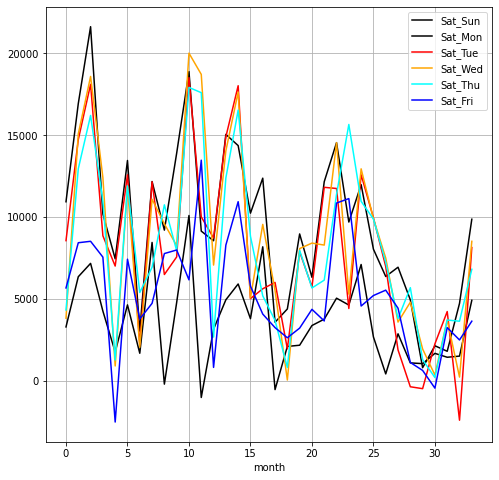

In [78]:
ax = df4p.plot(x="month",y="Sat_Sun",kind="line",grid=True,figsize=(8,8),color="black")
df4p.plot(x="month",y="Sat_Mon",kind="line",grid=True,figsize=(8,8),ax=ax,color="black")
df4p.plot(x="month",y="Sat_Tue",kind="line",grid=True,figsize=(8,8),ax=ax,color="red")
df4p.plot(x="month",y="Sat_Wed",kind="line",grid=True,figsize=(8,8),ax=ax,color="orange")
df4p.plot(x="month",y="Sat_Thu",kind="line",grid=True,figsize=(8,8),ax=ax,color="cyan")
df4p.plot(x="month",y="Sat_Fri",kind="line",grid=True,figsize=(8,8),ax=ax,color="blue")

In [0]:
# We should consider weighting each month's sales, or having an extra column to describe the number of days in the month,
#    and how many of these days are Saturdays (substantially larger sales), Sundays, and Fridays (big sale days also):
#                                Sunday    Monday   Tuesday   Wednesday   Thursday    Friday   Saturday
# mean sales per month (0-33):   17,700    11,700   13,300    12,800      13,200      16,000   21,300

# we could multiply each month's sales by the fraction of such days compared to the test month (nov 2015) (i.e., normalize each month's sales)

# sales seem to slow near the end of our training data, and differences in sales by day of the week also seem far less prominent than earlier months
#   from stock market records, it seems as if Russia had a minor recession in mid-2015, and just started to emerge in Oct/Nov 2015... perhaps there is a good measure of personal spending, better than stock prices
#    (i.e., is there a Personal Consumption Expenditures (PCE) index for Russia like in the US?)
# maybe we should exclude xmas-new year spikes and a few other anomalies (just remove them from dataframe), then do linear regression to find slope and offset of sales per day for each day
#  then use that set of 7 equations (one per weekday) and count of number of each one of the week days in a month, then normalize to what the sales would be for each month if each month
#  had the same number and distribution of days as Nov 2015

# perhaps also then go back and clip sales per day (or similar metric) to conform to these linear fits, so as to reduce the effect of spikes in sales around new year and late feb, etc.
#  because we don't want these spiky features to be lagged into future months

##Explore correlations related to sales amounts, for 
* individual categories (e.g. item_category_id #n vs. item_category_id #n+1)
* category pairs (e.g., sales in item_category_id #n vs. shop_id #m)
* lagged values (e.g., item_category_id #n vs. item_category_id #n lagged by x amount)
* * lagged values can be shifted by days, weeks, months, quarters

In [80]:
# To Do:
'''
#####################
# START: correlations without NLP:  look at item_cnt_day numbers, and find which things to group to make decision tree algorithms more effective and predictive
#####################

How to best check sales correlations between elements/groups?
- clip daily sales at [0,20] before grouping
- use self-correlation with time lag to see what are the best lag features to use (maybe grouped by month first, with lags =1 to 15 and 
      grouped by shop_id(fastest) or item_cat_id or item or shop_item or shop-item_cat / pivot so shop or item number = column number)
- look at correlation between shops and between items and between shop-item and item_category_ids for different lags and for different items; see if we can reduce number of category_ids, or if we should increase

#####################
# END: correlations without NLP
#####################



#####################
# START: thoughts on adjustments to make to the NLP section of this ipynb, if we should wish to continue on this route...
#####################

re.findall isn't consistent... sometimes gives a list of an array of tuples (many of which are empty string, but a matching string will be in any one of the tuple positions... and, possibly more than one??), so x=[("",""," dvd","")] and x[0] gives the tuple, and x[0][0]=''
sometimes gives a list of a single string, so x[0] = 'abbyy' and x[0][0]='a'
--> maybe add an extra df column for ngrams to append, and merge it with the delim_item_strings after all 'cleaning' is done

explicitly concatenate the item category name as a n-gram string, with n the same for all categories (pad as needed); don't add it to string before separating

focus on any of the 84 categories that have the most items or the most spread in behavior... split apart the ones with odd behavior, or the ones that are sold by  a subset of shops consistently
(original train set: item_cat_id.counts()
(original train set: item_cat_id - item_cnt_day.value_counts()
(group by item_cat_id (agg: counts); then do shop_id.counts()
(group by month and item_cat_id; look at sum of sales by item_cat_id for last xx months, and characterize the various groups with min/max/std over past n months, for several n)
--> look after stripping the version numbers, etc. off the games and software, and create new groups based on only that??
--> can also try combining similar of the 84 categories (e.g., all playstations, or all xboxes, or all tickets/cards/...) and see if we have more consistent performance within a category
--> can also look at top 50 clusters created by NLP, and see how correlated their sales are, within a cluster, vs. uncorrelated outside a cluster

###
maybe create a combination category column like grouping certain shop-item pairs, or shop-item_category pairs, or shop_cat-item_cat pairing

####
look at most common n-grams for the cleaned/non-delimited item name
(start with n=15 and work backwards to n=1)
clean/replace as much as possible without overly distorting the item name
then:
for each n:
--> split clean string into consecutive n-grams and put them in df columns, where the # columns in df = largest number of n-grams for any of the item names (search to find longest name, and calculate how many columns are needed/used)
--> in each column, do count_values... perhaps do a combined unique() to get all the n-grams, then put into an array or series containing the n-gram string and the sum of value_counts over each column
--> sort by frequency, and choose the ? top 100 and ? bottom 100 (for sum>1)
--> convert some of the desired n-grams into n+x grams to reflect the relative importance?

#####################
# END: adjustments to make to the NLP section of this ipynb...
#####################
'''

print(f'done: {strftime("%a %X %x")}')

done: Sun 09:00:31 05/31/20


##2.x.1.x) Explore Correlation Type:
* **item_category_id** - **item_category_id** correlation 
* sales grouped by **week** (and **item_category_id**)
</br>

* Pearson correlation between sales of item categories for each week; threshold at a certain value (e.g., above 0.92) to indicate sufficient correlation to include.  Then, use neworkX and graph clustering to extract groups of tightly-clustered item_category_ids


In [81]:
# Start by setting desired parameters:

# before grouping:
daily_sales_max_clip = 20
daily_sales_min_clip = 0
drop_test_month = True

fillna0 = True                      # perform fillna(0) on dataframe before computing correlations between feature categories
correlation_threshold = 900         # 1000x the computed correlation coefficient; only pairs with correlation coefficients greater than this get included in cluster determination
corr_method = 'pearson'             # 'kendall' or 'pearson' or 'spearman'
min_samples_corr = 4
n_ids = len(item_categories_augmented)

group_time_period = 'week'
group_category = 'item_category_id'
agg_column = 'sales'                # sum of this when grouping by the above

print(f'done: {strftime("%a %X %x")}\n')

done: Sun 09:00:31 05/31/20



###create category vs. sales (by time_period) dataframe, on which to do correlation examination

In [82]:
df_keep = [group_time_period,agg_column,group_category]
df_groupby = [group_time_period,group_category]
pivot_idx = group_time_period
pivot_cols = group_category
pivot_values = agg_column

# clipping daily shop-item pair sales as desired, then drop test month if desired, then group by time=group_time_period and by cat=group_category (dropping unnecessary columns)
# finally, pivot the dataframe so columns correspond to different categories, and rows correspond to different time periods
time_cat = tt.copy(deep=True)
time_cat.sales.clip(daily_sales_min_clip, daily_sales_max_clip, inplace=True)
if drop_test_month:
    time_cat = time_cat[time_cat.month < 34]
time_cat = time_cat[df_keep].groupby(df_groupby).sum().reset_index()
time_cat = time_cat.pivot(index = pivot_idx, columns = pivot_cols, values = pivot_values)

print(f'done: {strftime("%a %X %x")}\n')
print(f'Pivoted dataframe shape for sales per {group_category}, summed within each {group_time_period}: {time_cat.shape}\n')
print(time_cat.describe(),'\n')
time_cat.head()

done: Sun 09:00:33 05/31/20

Pivoted dataframe shape for sales per item_category_id, summed within each week: (148, 84)

item_category_id  0   1       2       3      4      5       6       7       8      9   10     11      12  ...        71      72      73    74      75     76     77     78      79      80     81      82      83
count              3   2     148     148    115    148     148      58      38    147   1    145     101  ...       139     148     148    33     148    131    131    131     148      23     72      80     148
mean               1   1 132.858 201.709 21.043 50.270 138.520  92.552 227.026 80.082   1 44.407 121.386  ... 1,183.655 341.412  98.777 1.788 325.007 42.992 29.824 19.160 106.858 175.435 13.417 127.412  81.324
std                0   0 120.410 161.193 18.137 36.236  74.904 111.150 406.730 63.054 nan 47.196 143.290  ...   537.216 211.009  36.240 0.893 143.991 18.624 36.191 11.589 120.415 279.584 12.705 108.196  57.065
min                1   1      12      2

item_category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,...,71,72,73,74,75,76,77,78,79,80,81,82,83
week,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,nan,nan,390,129,80,206,209,nan,nan,nan,nan,108,nan,...,68,144,71,nan,516,nan,99,nan,23,nan,32,239,282
1,1,1,350,95,34,154,219,nan,nan,21,nan,91,nan,...,nan,215,148,nan,744,nan,134,nan,24,nan,42,325,219
2,nan,nan,257,85,53,107,181,nan,nan,55,nan,77,nan,...,3,178,177,nan,725,nan,96,nan,11,nan,38,310,135
3,nan,nan,246,85,53,100,166,nan,nan,34,nan,58,nan,...,nan,168,157,nan,590,nan,89,nan,41,nan,43,286,163
4,nan,nan,243,66,54,80,160,nan,nan,46,nan,66,nan,...,2,134,190,nan,616,nan,106,nan,55,nan,39,251,136


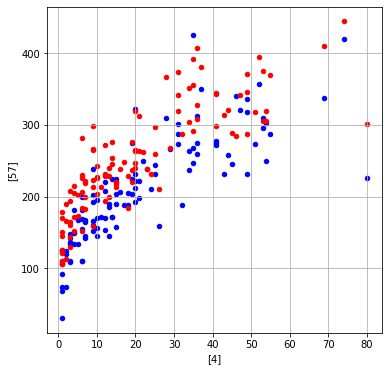

In [83]:
#sns.pairplot(cat_cat.iloc[:][:4])  # can't seem to get this multiple-plot grid to work in a reasonable amount of time (even with GPU, stopped this 2x2 grid afer 20min of incompletion)

#time_cat.plot.scatter(x=[59,59,59],y=[66,77,82],figsize=(5,5),grid=True)
#time_cat.plot.scatter(x=[59],y=[80],figsize=(5,5),grid=True, c='DarkBlue') #12,3,20    # look at single columns vs. each other in a single scatter plot... item_category_ids 3 and 12 seem to be well correlated, also 6 and 15
# # [59, 66, 77, 82]	
# ax = time_cat.plot.scatter(x=[59],y=[66], color='blue',figsize=(5,5),grid=True)
# time_cat.plot.scatter(x=[59],y=[77], color='red', ax=ax, grid=True)
# time_cat.plot.scatter(x=[59],y=[82], color='green', ax=ax, grid=True)

# [2, 4, 5, 11, 21, 30, 40, 43, 57, 62, 75]
ax = time_cat.plot.scatter(x=[4],y=[43], color='blue',figsize=(6,6),grid=True)
time_cat.plot.scatter(x=[4],y=[57], color='red', ax=ax, grid=True)
# time_cat.plot.scatter(x=[2],y=[11], color='green', ax=ax, grid=True)
# time_cat.plot.scatter(x=[2],y=[21], color='orange', ax=ax, grid=True)
# #time_cat.plot.scatter(x=[2],y=[30], color='cyan', ax=ax, grid=True)
# #time_cat.plot.scatter(x=[2],y=[40], color='black', ax=ax, grid=True)
# time_cat.plot.scatter(x=[2],y=[43], color='yellow', ax=ax, grid=True)
# time_cat.plot.scatter(x=[2],y=[57], color='DarkBlue', ax=ax, grid=True)
# time_cat.plot.scatter(x=[2],y=[62], color='DarkRed', ax=ax, grid=True)
# time_cat.plot.scatter(x=[2],y=[75], color='DarkGreen', ax=ax, grid=True)

###category vs. category  correlation matrix

In [84]:
if fillna0:
    corr_matrix = time_cat.fillna(0).corr(method=corr_method, min_periods=min_samples_corr)
else:
    corr_matrix = time_cat.corr(method=corr_method, min_periods=min_samples_corr)

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix.head()

done: Sun 09:00:34 05/31/20



item_category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,...,71,72,73,74,75,76,77,78,79,80,81,82,83
item_category_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0.398,0.135,-0.120,0.224,0.215,0.042,-0.063,-0.037,-0.117,-0.012,0.044,-0.091,...,-0.270,-0.133,0.322,-0.067,0.298,-0.247,0.345,-0.196,-0.096,-0.031,0.322,0.280,0.212
1,0.398,1,0.213,-0.083,0.243,0.242,0.121,-0.051,-0.030,-0.079,-0.010,0.088,-0.074,...,-0.220,-0.077,0.184,-0.055,0.328,-0.201,0.391,-0.159,-0.074,-0.025,0.291,0.274,0.238
2,0.135,0.213,1,0.277,0.591,0.863,0.832,-0.158,-0.148,-0.315,-0.003,0.924,0.254,...,0.231,0.151,0.396,-0.247,0.746,-0.304,0.466,-0.055,-0.322,-0.198,0.369,0.381,0.204
3,-0.120,-0.083,0.277,1,-0.323,0.194,0.528,0.524,0.136,0.307,-0.082,0.303,0.786,...,0.521,0.782,-0.318,0.216,-0.026,0.517,-0.422,0.339,0.418,0.058,-0.455,-0.497,-0.053
4,0.224,0.243,0.591,-0.323,1,0.748,0.326,-0.316,-0.184,-0.502,0.089,0.496,-0.200,...,-0.205,-0.428,0.670,-0.352,0.765,-0.668,0.888,-0.363,-0.504,-0.195,0.845,0.891,0.495


In [85]:
corr_matrix_scrubbed = round(corr_matrix.fillna(0) * 1000)
corr_matrix_scrubbed = corr_matrix_scrubbed.apply(pd.to_numeric,  downcast='integer')
for i in range(corr_matrix_scrubbed.shape[0]):  #set diag to zeros
    corr_matrix_scrubbed.at[i,i] = 0
#corr_matrix_scrubbed.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_scrubbed.iloc[58:60,59:84]

done: Sun 09:00:34 05/31/20



item_category_id,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
item_category_id,,,,,,,,,,,,,,,,,,,,,,,,,
58,-264,100,448,232,590,684,624,-223,394,18,732,486,402,714,-167,340,49,525,-273,277,548,-26,-292,-334,114
59,0,571,-463,595,-194,-229,-97,941,442,586,-181,-166,-362,-544,755,-332,757,-740,952,-406,-477,-155,885,947,528


In [86]:
corr_matrix_ids_masked = corr_matrix_scrubbed > correlation_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_ids_masked = corr_matrix_ids_masked.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards

print(f'done: {strftime("%a %X %x")}\n')

print(f'Top 10 categories having most number of correlated categories:\n{corr_matrix_ids_masked.nunique().sort_values(ascending=False)[:10]}\n')
#corr_matrix_ids_masked.head()

corr_matrix_ids_masked.iloc[58:60,59:84]

done: Sun 09:00:34 05/31/20

Top 10 categories having most number of correlated categories:
item_category_id
66    6
82    5
40    5
59    4
77    4
4     3
57    3
43    3
21    3
2     3
dtype: int64



item_category_id,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
item_category_id,,,,,,,,,,,,,,,,,,,,,,,,,
58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,60,0


###correlation matrix heatmaps

<IPython.core.display.Javascript object>

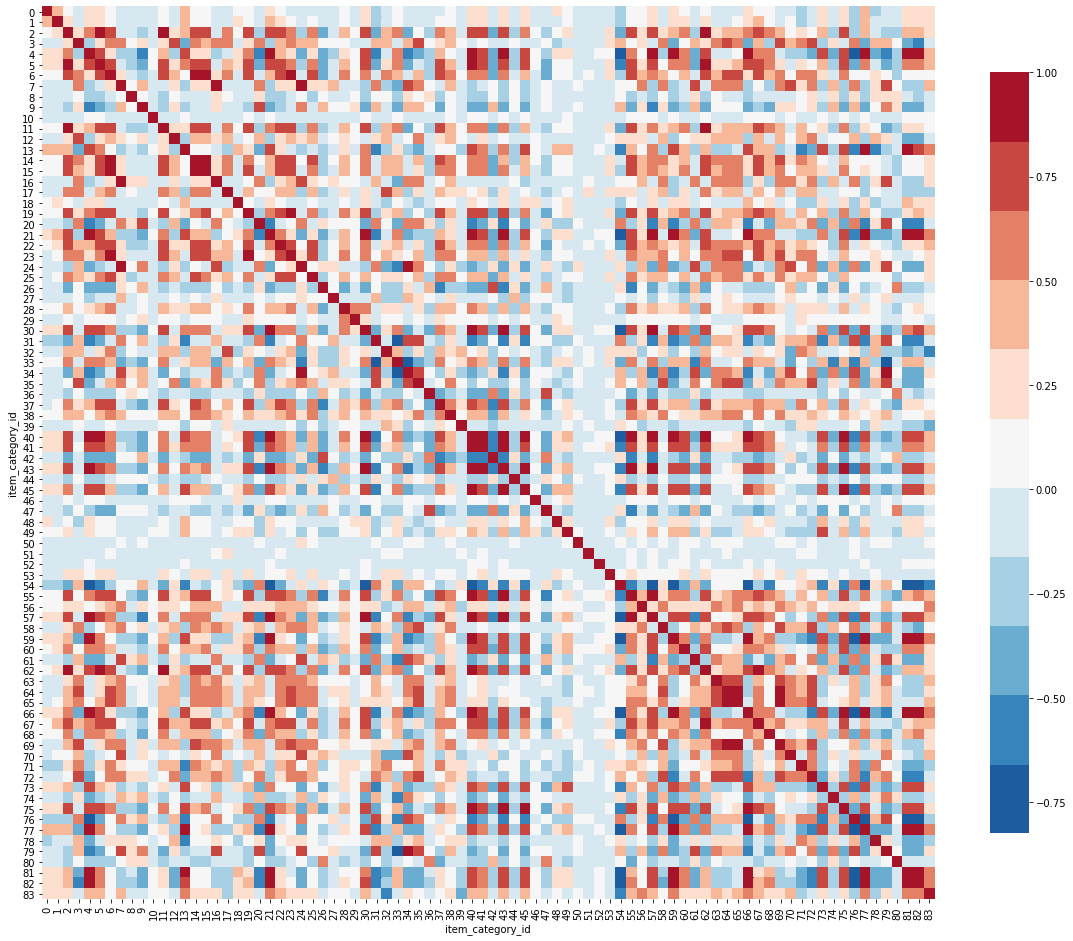

In [87]:
# heatmap of the correlation coefficients with row and column axes = category ids, in numerical order
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

h = sns.heatmap(corr_matrix,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

<IPython.core.display.Javascript object>

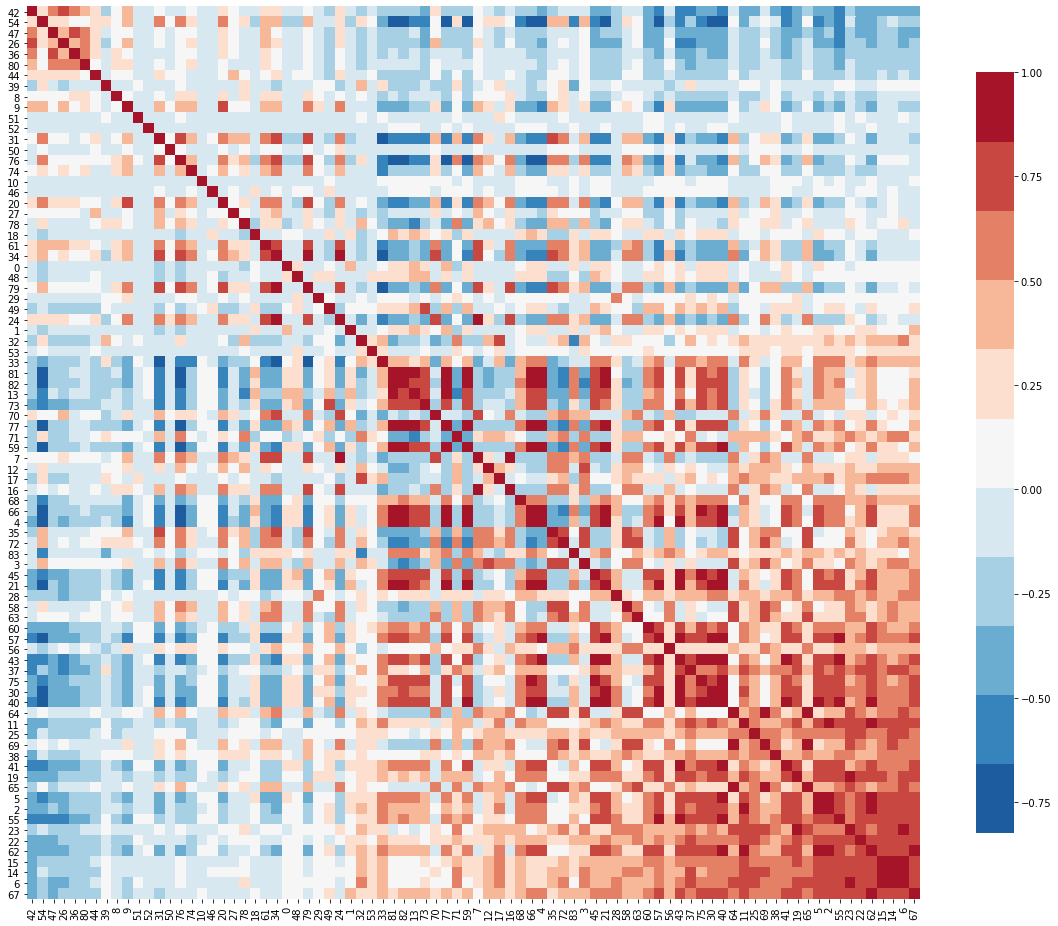

In [88]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#    sort by: sum of all correlation numbers in a column
df = corr_matrix.copy(deep=True).reset_index(drop=True)
sortedidx = df.sum(axis=1).sort_values().index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

<IPython.core.display.Javascript object>

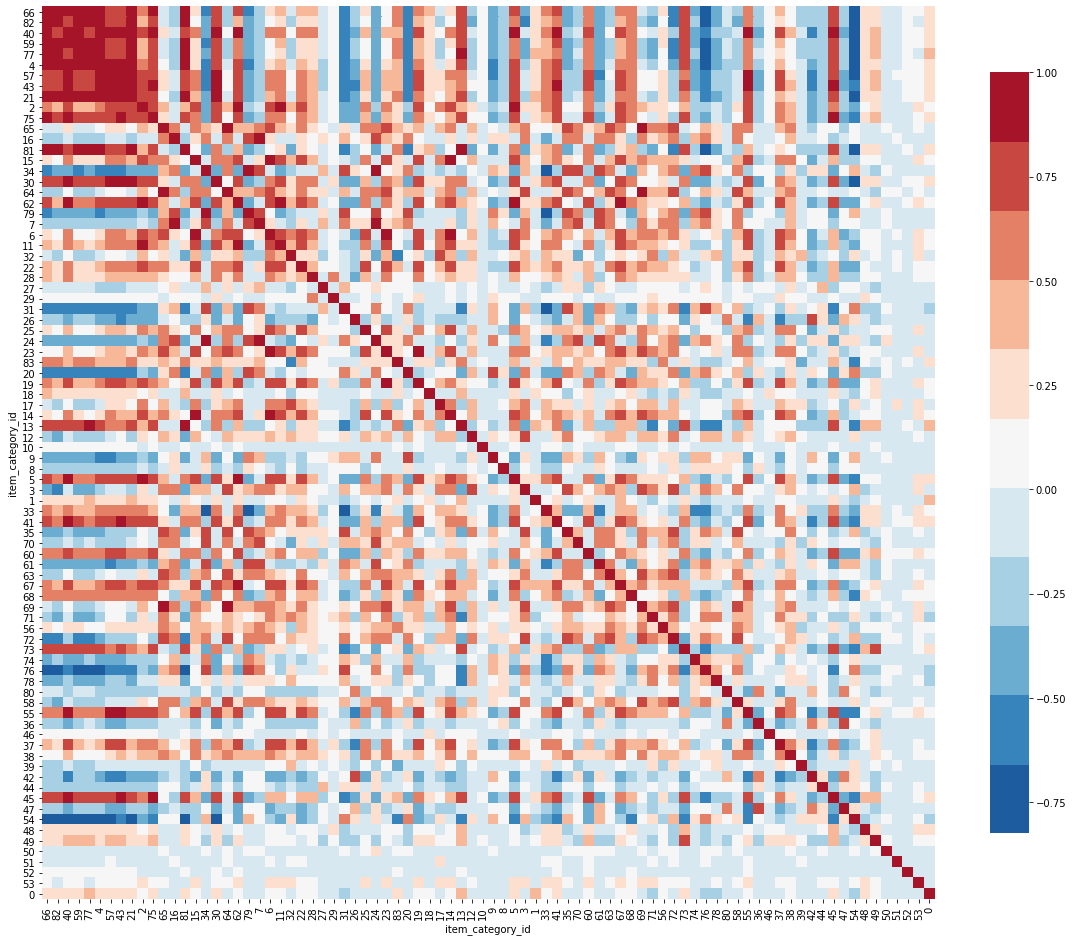

In [89]:
# look at a sorted version of the correlation matrix to see which items are most heavily correlated with others
#   sort by: count of number of items correlated above the threshold
df2 = corr_matrix.copy(deep=True).reset_index(drop=True)
sortedidx = corr_matrix_ids_masked.nunique().sort_values(ascending=False).index 
df = df.reindex(index=sortedidx, columns=sortedidx)
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
h = sns.heatmap(df,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

###create networkX graph and perform clustering

In [90]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
cat_friends = pd.DataFrame({'category1':[x for x in range(n_ids) if corr_matrix_ids_masked[x].sum()>0]})
cat_friends['category2'] = cat_friends.category1.apply(lambda x: [i-1 for i in corr_matrix_ids_masked[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
cat_friends = cat_friends.explode('category2').reset_index(drop=True)
cat_friends['weight'] = cat_friends.apply(lambda x: corr_matrix_scrubbed.at[x.category1,x.category2], axis=1)
cat_friends = cat_friends[cat_friends.weight > 0].reset_index(drop=True)
print(f'done: {strftime("%a %X %x")}\n')
print(f'Number of pairs meeting the threshold limit: {len(cat_friends)}')
unique_nodes = list(cat_friends.category1.unique()) + list(cat_friends.category2.unique())
set_unique_nodes = set(unique_nodes)
print(f'Number of unique category ids in the pairs meeting the threshold limit: {len(set_unique_nodes)}\n')
print(cat_friends.head(50))

# create a graph with nodes = item category ids, and edge weights = correlation coeffs * 1000

edge_threshold = correlation_threshold  # correlation*1000 (edge weight) must be greater than this for two item_ids to be connected in the graph
cat_friends = cat_friends[cat_friends.weight > edge_threshold]

# import pandas df into weighted-edge graph:
G = nx.from_pandas_edgelist(cat_friends, 'category1', 'category2', ['weight'])
print(f'\nWeighted-edge graph G formation done: {strftime("%a %X %x")}\n')

done: Sun 09:00:41 05/31/20

Number of pairs meeting the threshold limit: 42
Number of unique category ids in the pairs meeting the threshold limit: 23

    category1 category2  weight
0           2        11     924
1           2        62     920
2           4        21     937
3           4        66     903
4           6        15     912
5           7        16     912
6          11         2     924
7          15         6     912
8          16         7     912
9          21         4     937
10         21        66     914
11         30        40     910
12         34        79     932
13         40        30     910
14         40        43     933
15         40        57     918
16         40        75     911
17         43        40     933
18         43        57     935
19         57        40     918
20         57        43     935
21         59        66     941
22         59        77     952
23         59        82     947
24         62         2     920
25         64  

In [91]:
# employ a clustering method that utilizes the edge weights
communities = community.asyn_lpa_communities(G, weight='weight', seed=42)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

done: Sun 09:00:41 05/31/20



In [0]:
# extract information from the clustering algorithm's community grouping, and insert into df
num_communities = 0; community_items = set()
#cluster_nodes, n_nodes = [], []
comm_info = OrderedDict({'n_nodes':[],'w_avg':[],'w_sum':[],'w_max':[],'w_min':[],'w_std':[],'cluster_members':[]})
for i,c in enumerate(communities):
    edgeweights = []; num_communities += 1
    community_items = community_items | set(c)
    nodelist = list(c); nnodes = len(nodelist)
    for m in range(nnodes-1):
        for n in range(m+1,nnodes):
            try:
                edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
            except:
                pass   
    comm_info['n_nodes'].append(nnodes)
    comm_info['cluster_members'].append(sorted(nodelist))
    comm_info['w_avg'].append(round(np.mean(edgeweights)))
    comm_info['w_sum'].append(np.sum(edgeweights)); comm_info['w_max'].append(np.max(edgeweights))
    comm_info['w_min'].append(np.min(edgeweights)); comm_info['w_std'].append(np.std(edgeweights))

community_df = pd.DataFrame(comm_info) # create dataframe with cluster info
community_df['category_names'] = community_df.cluster_members.apply(lambda x: [item_categories_augmented.at[catid,'en_cat_name'] for catid in x])  # useful for short names; add column containing names of things in each cluster
community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)  # sort dataframe so highest average correlation clusters are first (larger num_nodes clusters are prioritized if tie in corr)
all_cluster_item_ids = community_df.cluster_members.sum()
unique_cluster_item_ids = set(all_cluster_item_ids)

###results of graph clustering algorithm

In [93]:
# Display the results

print(community_df.describe())
print("\n")

print(f'done: {strftime("%a %X %x")}')
print(f'\nCorrelation Threshold (1000x): {correlation_threshold:d}')
print(f'Correlation Method: {corr_method}')
print(f'Minimum number of periods for correlation calc: {min_samples_corr}')
print(f'Daily sales clip limits before grouping: {daily_sales_min_clip:d}, {daily_sales_max_clip:d}')
print(f'Drop test month (= 34) before grouping?: {drop_test_month}')
print(f'Fill fillna(0) before computing correlations?: {fillna0}')
print(f'Grouping time period: by {group_time_period}')
print(f'Grouping category: by {group_category}')
print(f'Aggregation column: sum of {agg_column} within a {group_time_period} for each {group_category}')
print(f'Number of community clusters identified in the graph: {num_communities}')
print(f'Total number of ids in all suggested clusters): {len(all_cluster_item_ids)}')
print(f'Number of *unique* ids contained in all clusters: {len(unique_cluster_item_ids)}\n')
print('In the following table, "w" refers to the weights between graph nodes = 1000x correlation coefficient:')
print(community_df.head(10))

       n_nodes   w_avg     w_sum   w_max   w_min  w_std
count        8       8         8       8       8      8
mean     2.875 924.750 2,203.375 928.625 919.750  3.150
std      1.356   9.996 2,173.179  13.394  10.593  5.284
min          2     912       912     912     910      0
25%          2 918.750   921.750     921 911.500      0
50%          2 923.500   934.500 928.500     916      0
75%      3.500 933.250 2,534.750 935.500 926.750  4.167
max          5     937      6558     952     937 12.529


done: Sun 09:00:41 05/31/20

Correlation Threshold (1000x): 900
Correlation Method: pearson
Minimum number of periods for correlation calc: 4
Daily sales clip limits before grouping: 0, 20
Drop test month (= 34) before grouping?: True
Fill fillna(0) before computing correlations?: True
Grouping time period: by week
Grouping category: by item_category_id
Aggregation column: sum of sales within a week for each item_category_id
Number of community clusters identified in the graph: 8
Total num

In [94]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

k=10
# what are the top-10 most correlated categories?
# remove everything under diagonal so we don't get duplicate results
for i in range(len(corr_matrix_scrubbed)):
    for j in range(i):
        corr_matrix_scrubbed.at[i,j] = 0
corr_npy = corr_matrix_scrubbed.to_numpy()
cms_top_idxs = largest_indices(corr_npy, k)
cms_top_vals = corr_npy[cms_top_idxs]
top_k = pd.DataFrame({'cat1':cms_top_idxs[0], 'cat2':cms_top_idxs[1], 'corr':cms_top_vals})
top_k['category_names'] = top_k.apply(lambda x: [item_categories_augmented.at[x.cat1,'en_cat_name'], item_categories_augmented.at[x.cat2,'en_cat_name'] ], axis = 1) 


print(f'done: {strftime("%a %X %x")}\n')

print(f'Top {k} most-strongly-correlated pairs:')
top_k

done: Sun 09:00:41 05/31/20

Top 10 most-strongly-correlated pairs:


,cat1,cat2,corr,category_names
0,59,77,952,"[Music - Music video, Program - Educational]"
1,59,82,947,"[Music - Music video, Net carriers (piece)]"
2,59,66,941,"[Music - Music video, Gifts - Cards, Stickers]"
3,66,77,939,"[Gifts - Cards, Stickers, Program - Educational]"
4,4,21,937,"[Accessories - PSP, Games - PSP]"
5,77,82,937,"[Program - Educational, Net carriers (piece)]"
6,43,57,935,"[Books - Audiobooks, Music - MP3]"
7,40,43,933,"[Movie - DVD, Books - Audiobooks]"
8,81,82,932,"[Net carriers (spire), Net carriers (piece)]"
9,34,79,932,"[Payment cards - Live! (Numeral), System Tools]"


In [95]:
lr=mgcd # dummy code to stop execution of "run after" menu option, so we don't go into all the stuff below

NameError: ignored

#2.5) ***items*** Dataset: EDA, Cleaning, Correlations, and Feature Generation

---



---



###2.5.1) Initial data exploration and Russian -> English translation

####Thoughts regarding items dataframe
Let's first look at how many training examples we have to work with...

Many of the items have similar names, but slightly different punctuation, or only very slightly different version numbers or types.  (e.g., 'Call of Duty III' vs. 'Call of Duty III DVD')

One can expect that these two items would have similar sales in general, and by grouping them into a single feature category, we can eliminate some of the overfitting that might come as a result of the relatively small ratio of (training set shop-item-date combinations = 2935849)/(total number of unique items = 22170).  (This is an average of about 132 rows in the sales_train data for each shop-item-date combination that we are using to train our model.  Our task is to produce a monthly estimate of sales (for November 2015), so it is relevant to consider training our model based on how many sales in a month vs. how many sales in the entire training set.  Given that the sales_train dataset covers the time period from January 2013 to October 2015 (34 months), we have on average fewer than 4 shop-item combinations in our training set for a given item in any given month.  Furthermore, as we are trying to predict for a particular month (*November* 2015), it is relevant to consider how many rows in our training set occur in the month of November.  The sales_train dataset contains data for two 'November' months out of the total 34 months of data.  Another simple calculation gives us an estimate that our training set contains on average 0.23 shop-item combinations per item for November months.

To summarize:

*  *sales_train* contains 34 months of data, including 2935849 shop-item-date combinations
*  *items* contains 22170 "unique" item_id values

In the *sales_train* data, we therefore have:
*  on average, 132 rows with a given shop-item pair for a given item_id
*  on average, 4 rows with a given shop-item pair for a given item_id in a given month
*  on average, 0.23 rows with a given shop-item pair for a given item_id in all months named 'November'

If we wish to improve our model predictions for the following month of November, it behooves us to use monthly grouping of sales, or, even better, November grouping of sales.  This smooths out day-to-day variations in sales for a better monthly prediction.  However, the sparse number of available rows in the *sales_train* data will contribute to inaccuracy in our model training and predictions.

Imagine if we could reduce the number of item_id values from 22170 to perhaps half that or even less.  Given that the number of rows for training (per item, on a monthly or a November basis) is so small, then such a reduction in the number of item_id values would have a big impact.  (The same is true for creating features to supplement "shop_id" so as to group and reduce the individuality of each shop - and thus effectively create, on average, more rows of training data for each shop-item pair.

####Translate and Ruminate
We will start by translating the Russian text in the dataframe, and add our ruminations on possible new features we can generate.

The dataframe *items_transl* (equivalent to *items* plus a column for English translation) is saved as a .csv file so we do not have to repeat the translation process the next time we open a Google Colab runtime.

In [0]:
print(items_transl.info())
print("\n")
print(items_transl.tail(10))

###2.5.2) **NLP for feature generation from items data**
Automate the search for commonality among items, and create new categorical feature to prevent overfitting from close similarity between many item names

####**Delimited Groups of Words**

Investigating "special" delimited word groups (like this) or [here] or /hobbitville/ that are present in item names, and may be particularly important in creating n>1 n-grams for uniquely identifying items so that we can tell if two items are the same or nearly the same

#####Some details on the approach, and code for helper functions to clean and separate the text:

In [0]:
# explanation of regex string I'm using to parse the item_name
'''

^\s+|\s*[,\"\/\(\)\[\]]+\s*|\s+$

gm
1st Alternative ^\s+
^ asserts position at start of a line
\s+ matches any whitespace character (equal to [\r\n\t\f\v ])
+ Quantifier — Matches between one and unlimited times, as many times as possible, giving back as needed (greedy)

2nd Alternative \s*[,\"\/\(\)\[\]]+\s*
\s* matches any whitespace character (equal to [\r\n\t\f\v ])
* Quantifier — Matches between zero and unlimited times, as many times as possible, giving back as needed (greedy)
Match a single character present in the list below [,\"\/\(\)\[\]]+
+ Quantifier — Matches between one and unlimited times, as many times as possible, giving back as needed (greedy)
, matches the character , literally (case sensitive)
\" matches the character " literally (case sensitive)
\/ matches the character / literally (case sensitive)
\( matches the character ( literally (case sensitive)
\) matches the character ) literally (case sensitive)
\[ matches the character [ literally (case sensitive)
\] matches the character ] literally (case sensitive)
\s* matches any whitespace character (equal to [\r\n\t\f\v ])
* Quantifier — Matches between zero and unlimited times, as many times as possible, giving back as needed (greedy)

3rd Alternative \s+$
\s+ matches any whitespace character (equal to [\r\n\t\f\v ])
+ Quantifier — Matches between one and unlimited times, as many times as possible, giving back as needed (greedy)
$ asserts position at the end of a line

Global pattern flags
g modifier: global. All matches (don't return after first match)
m modifier: multi line. Causes ^ and $ to match the begin/end of each line (not only begin/end of string)
'''
print(f'done: {strftime("%a %X %x")}')  # prevent Jupyter from printing triple-quoted comments

In [0]:
# This cell contains no code to run; it is simply a record of some inspections that were done on the items database

# before removing undesirable characters / punctuation from the item name,
#   let's see if we can find n-grams or useful describers or common abbreviations by looking between the nasty characters
# first, let's see what characters are present in the en_item_name column
'''
nasty_symbols = re.compile('[^0-9a-zA-Z ]')
nasties = set()
for i in range(len(items_transl)):
  n = nasty_symbols.findall(items_transl.at[i,'en_item_name'])
  nasties = nasties.union(set(n))
print(nasties)
{'[', '\u200b', 'ñ', '(', ')', '.', 'à', '`', 'ó', '®', 'Á', 
'\\', 'è', '&', '-', ':', 'ë', '_', 'û', '»', '=', '+', ']', ',', 
'«', 'ú', "'", 'ö', '#', 'ä', ';', 'ü', '"', 'ô', '/', '№', 'é', 
'í', '!', '°', 'å', '*', 'ĭ', 'ð', '?', 'â'}
'''
# From the above set of nasty characters, it looks like slashes, single quotes, double quotes, parentheses, and square brackets might enclose relevant n-grams
# Let's pull everything from en_item_name that is inside ' ', " ", (), or [] and see how many unique values we get, and if they are n-grams or abbreviations, for example
# It also seems that many of the item names end in a single character "D" for example, which should be converted to DVD

# ignore the :&+' stuff for now...
# Let's set up columns for ()[]-grams, for last string in the name, and for first string in name, and for text that precedes ":", and for text that surrounds "&" or "+"
#   but first, we will strip out every nasty character except ()[]:&+'"/ and replace the nasties with spaces, then eliminating double spaces

'''
# sanity check:
really_nasty_symbols = re.compile('[^0-9a-zA-Z \(\)\[\]:&+\'"/]')
really_nasties = set()
for i in range(len(items_transl)):
  rn = really_nasty_symbols.findall(items_transl.at[i,'en_item_name'])
  really_nasties = really_nasties.union(set(rn))
print(really_nasties)
{'\u200b', 'ñ', '.', 'à', '`', 'ó', '®', 'Á', '\\', 'è', '-', 'ë', '_', 'û', '»', '=', ',', '«', 'ú', 'ö', '#', 'ä', ';', 'ü', 'ô', '№', 'é', 'í', '!', '°', 'å', '*', 'ĭ', 'ð', '?', 'â'}
OK, looks good
'''
print(f'done: {strftime("%a %X %x")}')  # prevent Jupyter from printing triple-quoted comments

In [0]:
#  Start by defining stopwords and delimiters and punctuation that we wish to remove
#  Then, create a couple of functions to use for text cleaning, and for extracting delimited text n-grams

# stopwords to remove from item names (these are only a bit better than arbitrary selections from large stopwords lists -- may be worth adjusting them)
stop_words = "a,the,an,only,more,are,any,on,your,just,it,its,has,with,for,by,from".split(",")

# pre-compile regex strings to use for fast symbol removal or delimiting
nasty_symbols_re = re.compile(r'[^0-9a-zA-Z ]')  # remove all punctuation
really_nasty_symbols_re = re.compile(r'[^0-9a-zA-Z ,;\"\/\(\)\[\]\:\-\@]')  # remove nasties, but leave behind the delimiters
delimiters_re = re.compile(r'[,;\"\/\(\)\[\]\:\-\@\u00AB\u00BB~<>]')  # unicodes are << and >> thingies
# special symbols indicating a delimiter --> a space at start or end of item name will be removed at split time, along with ,;/()[]:"-@~<<>><>
delim_pattern_re = re.compile(r'^\s+|\s*[,;\"\/\(\)\[\]\:\-\@\u00AB\u00BB~<>]+\s*|\s+$') 
multiple_whitespace_re = re.compile(r'[ ]{2,}')

# pre-compile some specific regex strings to deal with inconsistencies in item names (more of this will be done later, after delimiting)
cleanup_text = {}
cleanup_text['preorder'] = re.compile(r'pre.?order')
cleanup_text[' dvd'] = re.compile(r'\s+d$')  #several item names end in "d" -- which actually seems to indicate dvd (because the items I see are in category 40: Movies-DVD)... standardize so d --> dvd
cleanup_text['digital version'] = re.compile(r'digital in$') # several items seem to end in "digital in"... maybe in = internet?, but looking at nearby items/categories, 'digital version' looks standard
cleanup_text['bluray dvd'] = re.compile(r'\bbd\b|\bblu\s+ray\b|\bblu\-ray\b|\bblueray\b|\bblue\s+ray\b|\bblue\-ray\b')
cleanup_text['007 : james bond : skyfall'] = re.compile(r'\bskyfall\b|\bskayfoll\b')
cleanup_text[' and '] = re.compile(r'[\&\+]')
cleanup_text[' xbox'] = re.compile(r'\bx[^0-9a-zA-Z ]box')  # anything like "x box" or "x-box" or "x%box" gets converted to a standard "xbox"
cleanup_text[' ps'] = re.compile(r'\bp[^0-9a-zA-Z ]s')      # attempt to do the same with "p-s4" --> "ps4"

def maid_service(text):
    """
    Compact routine to implement multiple regex substitutions using the above 'cleanup_text' dictionary
    """
    text = text.lower()
    for repl_text, pattern in cleanup_text.items():
        text = pattern.sub(repl_text, text)
    #r = re.compile(r'\bskayfoll\b')   # can add 'quickie' items here if you don't want to add to above dictionary, or if you want to perform something other than re.sub
    #text = r.sub('skyfall',text)  
    return text

def text_total_clean(text):
    """
    Gives a punctuation-free, cleaned, lemmatized version of the original English translation
    inputs: (text): the original en_item_name single-string, uncleaned, translated version of the Russian item name
    returns: single-string text, made lowercase, stripped of "really_nasties" and multiple spaces, and every word lemmatized
    """
    text = maid_service(text)
    text = delimiters_re.sub(" ", text)  # replace all delimiters with a space; other nasties get simply deleted
    text = nasty_symbols_re.sub("", text)  # delete anything other than letters, numbers, and spaces
    text = multiple_whitespace_re.sub(" ", text)  # replace multiple spaces with a single space
    text = text.strip() # remove whitespace around string
    # lemmatize each word
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split(" ") if w not in stop_words])
    return text

def text_clean_delimited(text):
    """
    Gives a punctuation-free, cleaned version of the original English translation, 
        but the function returns a list of strings instead of a single string,
        with each element in the list corresponding to text that was separated from neighboring
        text with one of the above-defined 'delimiter' characters
        (so, rather than analyzing the full item name for n-grams, we define an item's important
        n-grams as being separated by such delimiters.  It greatly reduces the number of n-grams we need to analyze)
    inputs: (text): the original en_item_name single-string, uncleaned, translated version of the Russian item name
    returns: en_item_name made lowercase, stripped of "really_nasties" and multiple spaces, 
        in a list of strings that had been separated by one of the above 'delimiters',
        and, with every word in every string lemmatized 
    """
    text = maid_service(text)
    text = really_nasty_symbols_re.sub("", text)  # just delete the nasty symbols
    text = multiple_whitespace_re.sub(" ", text)  # replace multiple spaces with a single space
    text = delim_pattern_re.split(text)           # split item_name at all delimiters, irrespective of number of spaces before or after the string or delimiter
    text = [x.strip() for x in text if x != ""]           # remove empty strings "" from the list of split items in text, and remove whitespace outside text n-gram
    # lemmatize each word
    lemtext = []
    for ngram in text:
        lemtext.append(" ".join([lemmatizer.lemmatize(w) for w in ngram.split(" ") if w not in stop_words]))
    return lemtext

print(f'done: {strftime("%a %X %x")}')

#####Add 'delimited' and 'cleaned' data columns; shorten the titles of other columns so dataframe fits better on the screen

In [0]:
items_delimited = items_transl.copy(deep=True)
# delete the wide "item_name" column so we can read more of the data table width-wise
items_delimited = items_delimited.drop("item_name", axis=1).rename(columns = {'en_item_name':'item_name','item_category_id':'i_cat_id'})
items_in_test_set = test.item_id.unique()
items_delimited["i_tested"] = False
for i in items_in_test_set:
  items_delimited.at[i,"i_tested"] = True


# add item_category name with delimiter to the item_name, as this will be useful info for grouping similar items (remove delimiting punctuation from cat names first, so it stays as one chunk of text)
items_delimited['item_name'] = items_delimited.apply(lambda x: text_total_clean(item_categories_augmented.at[x.i_cat_id,'en_cat_name']) + " : " + x.item_name, axis=1)

# add a column of simply cleaned text without any undesired punctuation or delimiters
items_delimited['clean_item_name'] = items_delimited['item_name'].apply(text_total_clean)

# now add a column of lists of delimited (cleaned) text
items_delimited['delim_name_list'] = items_delimited['item_name'].apply(text_clean_delimited)

# remove duplicate entries and single-character 1-grams to assist with operations to come later in this notebook
alphnum = list(string.ascii_lowercase) + list('1234567890')  # get rid of all length=1 1-grams
def remove_dupes_singles(gramlist):
    unwanted = set(alphnum)
    dupe_gramset = unwanted
    return [x for x in gramlist if x not in dupe_gramset and not dupe_gramset.add(x)]
items_delimited.delim_name_list = items_delimited.delim_name_list.apply(lambda x: remove_dupes_singles(x) )


# have a look at what we got with our delimited text globs
def maxgram(gramlist):
    maxg = 0
    for g in gramlist:
        maxg = max(maxg,len(g.split()))
    return maxg
items_delimited['d_len'] = items_delimited.delim_name_list.apply(lambda x: len(x))
items_delimited['d_maxgram'] = items_delimited.delim_name_list.apply(maxgram)

#items_delimited.to_csv("data_output/items_delimited.csv", index=False)

print(f'done: {strftime("%a %X %x")}')
print("\n")
print(items_delimited.describe())
print("\n")
print(items_delimited.iloc[31][:])
print("\n")
items_delimited.head()

In [0]:
# do some more text manipulation to help ensure items are properly grouped
#   also, expand the breadth of n-gram matches to ignore things like version number, in an effort to reduce the final number of clusters that are generated
#   (looking for perhaps 200 clusters instead of 2000+ that we get without this extra treatment (see 'items_nlp_clusters_v3...ipynb' ))

highlight_roots = OrderedDict()
cleanup_sub = OrderedDict()
cleanup_final = OrderedDict()
#cleanup_complete_replace = OrderedDict()


# for some matches, I want to only make a new entry in the list to standardize games to root values (e.g., "assasin creed special ops" = "assasin creed part 2")
#     The new list element will be a 5-gram, for example, to give it substantial weight when grouping items
#     The original list of delimited text will remain the same, so as to catch matches like "assasin creed special ops dvd bluray english version"

# use replacement text = '' if you want the create operation to use the match as a base string (possibly adding to it with fill_strings until n_gram size is reached)
games1 = "adventure of tintin|advanced warfare|army of two|assasin creed|angry bird|batman|battlefield|behind enemy line|black ops|borderland|call of duty|chaggington funny train"
games2 = "child of light|dark soul|dead space|disney infinity|dragon age|elder scroll|far cry|final fantasy|game of throne|god of war|grand theft auto|harry potter|james bond|(lord of ring|hobbit)"
games3 = "mario|masha and bear|max payne|medal of honor|men in black|metal gear solid|mickey mouse|might and magic|modern warfare|mortal kombat|nba|need speed|nhl|ninja storm|pirate of car\w*\b"
games4 = "plant v zombie|pro evolution|resident evil|secret of unicorn|shadow of mordor|sherlock holmes|sid meiers civilization|skylander|sniper elite|star war|stick of truth|street fighter"
games5 = "tiger wood|tom clancy(s)?|tomb raider|transformer|walking dead|warhammer|watch dog|witcher|world of warcraft"
popular_games = re.compile(rf'\b({games1}|{games2}|{games3}|{games4}|{games5})\b')
highlight_roots['compress game names to root values'] =     {'optype':['create'], 'reg_pattern':popular_games, 
                                                                'replacement_text':'', 'final_gram_n':5, 
                                                                'fill_strings':['game','computer','electronic','multirelease']}

lego = re.compile(r'\blego\b')
#lego = re.compile(rf'\b(lego.*({games1}|{games2}|{games3}|{games4}|{games5})?|({games1}|{games2}|{games3}|{games4}|{games5}).*lego)\b')
highlight_roots['lego products'] =                          {'optype':['create'], 'reg_pattern':lego,
                                                                'replacement_text':'lego brand lego style game'}

popular_companies = re.compile(rf'\b(1c|abbyy)\b')
highlight_roots['highlight product origins'] =              {'optype':['create'], 'reg_pattern':popular_companies, 
                                                                'replacement_text':'', 'final_gram_n':4, 
                                                                'fill_strings':['educational','software','learning']}

# for some of the matches, I just want to do an inplace substitution
fix_accessory_game = re.compile(r'\baccessory game\b')
cleanup_sub['game accessory'] =         {'optype':['sub'], 'replacement_text':'game accessory', 'reg_pattern':fix_accessory_game}

biz = re.compile(r'\b(firm|enterprise|company|corporation|shop|store|outlet)\b')
cleanup_sub['standardize biz'] =        {'optype':['sub'], 'replacement_text':'business', 'reg_pattern':biz}

digit = re.compile(r'\b(digital|download|online)(\s?(version|edition|set|box set))?\b')
cleanup_sub['special edition'] =        {'optype':['sub'], 'replacement_text':'online digital version', 'reg_pattern':digit}

special = re.compile(r'\b(collector|premier|platinum|special|suite)(.*(version|edition|set|box set|suite))?\b')
cleanup_sub['special edition'] =        {'optype':['sub'], 'replacement_text':'special version', 'reg_pattern':special}

std = re.compile(r'\b(standard|std)(\s?(edition|version|set|box set))?\b')
cleanup_sub['standard edition'] =       {'optype':['sub'], 'replacement_text':'standard version', 'reg_pattern':std}

russia = re.compile(r'\b(russian|ru)(\s?(edition|version|set|box set|documentation|instruction|language|format|subtitle|feature))?\b')
cleanup_sub['russian version'] =        {'optype':['sub'], 'replacement_text':'russian language version', 'reg_pattern':russia}

engl = re.compile(r'\b(english|en|eng|engl)(\s?(edition|version|set|box set|documentation|instruction|language|format|subtitle|feature))?\b')
cleanup_sub['english version'] =        {'optype':['sub'], 'replacement_text':'english language version', 'reg_pattern':engl}


# for other matches, I want to create a new n-gram and insert it into the list, and also do an inplace substitution
#   substitution text is made longer or shorter, depending on rough importance to matching (longer matching n-grams get more weight)
yo = re.compile(r'\b(yo|yoyo|yo yo)\b')
cleanup_final['yo yo yo'] =         {'optype':['sub','create'], 'replacement_text':'yo yo toy game fun', 'reg_pattern':yo}

music = re.compile(r'\b(cd mirex|mirex cd|cd mirex cd|vinyl|cd.*production firm|cd.*local production|mp3)(\s?(cd mirex|mirex cd|cd mirex cd|vinyl|cd.*production firm|cd.*local production|mp3))?\b')
cleanup_final['music media'] =      {'optype':['sub','create'], 'replacement_text':'music media', 'reg_pattern': music}

dvdclean = re.compile(r'\b(\d\s?)?(disc\s?)?(\d\s?)?dvd\b')
cleanup_final['dvd'] =             {'optype':['sub','create'], 'replacement_text':'dvd', 'reg_pattern':dvdclean}

brdvd = re.compile(r'\b(4k\s?)?(\d\s?)?(bluray\s?)?(\d\s?)?(dvd\s?)?(and\s?)?(\d\s?)?(disc\s?)?(4k\s?)?(\d\s?)?bluray(\s?and)?(\s?4k)?(\s?(\d\s?)?dvd)?(\s?4k)?(\s?and)?(\s?(\d\s?)?dvd)?\b|\b2bd\b')
cleanup_final['bluray dvd'] =      {'optype':['sub','create'], 'replacement_text':'bluray dvd', 'reg_pattern':brdvd}

br3d=re.compile(r'\b(\d\s?)?(disc)?\s?(\d\s?)?(dvd)?\s?(and)?\s?(3d\s?(\d\s?)?(dvd)?\s?(\d\s?)?bluray\s?(\d\s?)?(dvd)?|(\d\s?)?bluray\s?(\d\s?)?(dvd)?\s?3d)\s?(\d\s?)?(bluray dvd)?\s?(3d)?\s?(and)?\s?(\d\s?)?(dvd)?\s?(3d)?\b')
cleanup_final['3d bluray dvd'] =   {'optype':['sub','create'], 'replacement_text':'3d bluray dvd', 'reg_pattern':br3d}

macregx = re.compile(r'\b(support\s?)?(mac|ipad|macbook|powerbook|imac|apple)(\s?support)?\b')
cleanup_final['pc'] =              {'optype':['create'], 'replacement_text':'mac computing platform product', 'reg_pattern':macregx}

pcregx = re.compile(r'\b(support\s?)?(pc|windows|microsoft windows)(\s?support)?\b')
cleanup_final['pc'] =              {'optype':['create'], 'replacement_text':'pc computing platform product', 'reg_pattern':pcregx}

playsta = re.compile(r'\b(support\s?)?p(sp|\s?s|\s?s?\s?(move|2|3|4|pro|vita|vita 1000))\b')
cleanup_final['sony playstn'] =    {'optype':['create'], 'replacement_text':'sony playstation gaming platform', 'reg_pattern':playsta}

xbox = re.compile(r'\bx?\s?box\s?(one|360|live)(.*(kinect|knect))?\b')
cleanup_final['microsoft xbox'] =  {'optype':['create'], 'replacement_text':'microsoft xbox gaming platform','reg_pattern':xbox}

kinect = re.compile(r'\b(support)?\s?m?\s?s?\s?(kinect|knect)\b')
cleanup_final['microsoft knect'] = {'optype':['create'], 'replacement_text':'microsoft xbox gaming platform', 'reg_pattern':kinect}

msoffice = re.compile(r'\b(microsoft office|ms office|m office|office mac|office home|office professional|home and office|office student|office enterprise)\b')
cleanup_final['ms office'] =       {'optype':['create'], 'replacement_text':'microsoft office productivity software', 'reg_pattern':msoffice}

educate = re.compile(r'\b(education|educational|development|course|school|history|lesson|accounting|b8)\b')
cleanup_final['educational dev'] = {'optype':['create'], 'replacement_text':'educational development training lessons', 'reg_pattern':educate}

paycard = re.compile(r'\b(payment|card|ticket|debit)(\s?(card|ticket|debit))?\b')
cleanup_final['payment card'] =    {'optype':['create'], 'replacement_text':'payment card ticket', 'reg_pattern':paycard}

licenses = re.compile(r'\b(subscription|renewal|1 year|extension|license)(.*(subscription|renewal|1 year|extension|license))?(.*(subscription|renewal|1 year|extension|license))?\b')
cleanup_final['licenses'] =        {'optype':['create'], 'replacement_text':'license renewal subscription extension', 'reg_pattern':licenses}

download = re.compile(r'\b(online|digital|download|access|without disc|without disk|epay)(.*(online|digital|download|access|without disc|without disk|epay|version|edition))?\b')
cleanup_final['downloads'] =       {'optype':['create'], 'replacement_text':'online download version', 'reg_pattern':download}

ship = re.compile(r'\b(delivery|deliver|postage|mail|send|ship|shipment)(.*(delivery|deliver|postage|mail|send|ship|shipment))?\b')
cleanup_final['shipping'] =        {'optype':['create'], 'replacement_text':'shipping delivery postage', 'reg_pattern':ship}

virus = re.compile(r'\b(kaspersky|panda|drweb|eset nod32|security|antivirus|virus)(.*(kaspersky|panda|drweb|eset nod32|security|antivirus|virus|software))?\b')
cleanup_final['antivirus'] =       {'optype':['create'], 'replacement_text':'antivirus defender internet security software', 'reg_pattern':virus}

print(f'done: {strftime("%a %X %x")}')

In [0]:
# here are the routines to implement the above pattern-matching instructions, and modify the delim_items_list column of the dataframe

def expand_gram(gram,final_gram_n,fill_strings):
    for f in range(final_gram_n - len(gram.split())):
        gram = gram + " " + fill_strings[f]
    return gram

def cleanup_service(gramlist=["word1 this is a 6 gram", "word1", "two gram", "three gram string"], 
                    pattern_dict=OrderedDict({'replace 0007 with 007':{'optype':['sub'],'reg_pattern':re.compile(r'\b0007\b'), 'replacement_text':'007', 
                                                                       'final_gram_n':4, 'fill_strings':['game','computer','electronic']},
                                             'replace skayfall with skyfall':{'optype':['sub','create'],'reg_pattern':re.compile(r'\bskayfall\b'), 'replacement_text':'skyfall'}})):
    """
    for text modification in the items_delimited dataframe, in an effort to help standardize terms to better highlight similarities between items,
    and to help group items a bit more broadly in some cases, so we create fewer clusters with the following graph/network analysis.

    gramlist = list of delimited n-grams provided typically from a single cell from 'items_delimited' DF, at a single row, in column = 'delim_name_list'
    pattern_dict = ordered dictionary of lists where operations are done in the order created by user (e.g., clean up "dvd" variants before cleaning up "bluray dvd" variants, so the latter becomes simpler in regex)
        keys = representative text, describing what is being done (somewhat irrelevant to this function)
        values = dict{  
                    optype = list of strings indicating if one wants to do one or more of the following 4 types of operation on the gramlist
                            'sub': (sub)stitute regex matches, searching each element in the gramlist,  (len(gramlist) remains the same, but each string in gramlist may shrink or grow or remain unchanged)
                            'create': (create) new "standardized" list elements if a match is found within the gramlist (so len(gramlist) grows by 1 for each match); original gramlist strings remain unchanged
                            'complete_replace': wherever you have matching elements in the gramlist, replace the entire gramlist element with the pattern_dict key (len(gramlist) remains the same, but n in each n-gram may change)
                    reg_pattern = regex patterns to find/substitute/create/replace, 
                    replacement_text = the text to put in place of the reg_pattern match, or to use when creating a new gramlist list element
                    final_gram_n = integer; desired final n-gram length (if desired) 
                    fill_strings= list(padding strings used to append on to the shorter regex matches to make final string = n grams in length, in order from most important to least)... must be long enough!
                    }
    """
    print_counter = 0
    previous_gramlist = gramlist.copy()
    for key_text, op_details in pattern_dict.items():
        optype = op_details['optype']
        do_sub = 'sub' in optype
        do_create = 'create' in optype
        do_replace = 'complete_replace' in optype
        do_regfind = do_create or do_replace
        reg_pattern = op_details['reg_pattern']
        replacement_text = op_details['replacement_text']
        gram_set_n = False  # don't try to expand the n-gram to an (n+x)-gram unless the information is provided
        if 'final_gram_n' in op_details.keys():
            gram_set_n = True
            final_gram_n = op_details['final_gram_n']
        if 'fill_strings' in op_details.keys():
            fill_strings = op_details['fill_strings']
        else:
            gram_set_n = False

        updated_gramlist = previous_gramlist.copy()

        if do_sub:   # do substitutions first (cleanup), then do create, then do full replace
            for idx, gram in enumerate(previous_gramlist):
                updated_gramlist[idx] = reg_pattern.sub(replacement_text, gram)
            previous_gramlist = updated_gramlist.copy()

        if do_regfind:
            for idx, gram in enumerate(previous_gramlist):
                # if (key_text == 'highlight product origins'):
                #     pfind = reg_pattern.findall(previous_gramlist[idx])
                #     #ffind = reg_pattern.find(previous_gramlist[idx])
                #     sfind = reg_pattern.search(previous_gramlist[idx])
                #     if 'abbyy' in pfind:
                #         print(f'abby gram: {previous_gramlist[idx]}')
                #         print(f'abbyy 1 findall: {pfind}')
                #         #print(f'abbyy 1 find: {ffind}')
                #         print(f'abbyy 1 search: {sfind}')
                    # for adx,aptn in enumerate(pfind):
                    #     if 'abbyy' in aptn:
                    #         print(f'abbyy 2: position {adx}, element {aptn}, full find = {pfind}')
                    #     if 'abbyy' in aptn[0]:
                    #         print(f'abbyy 3: position {adx}, element {aptn}[0], full find = {pfind}')
                find_list = [x[0] for x in reg_pattern.findall(previous_gramlist[idx])]
                if find_list:  # proceed only if we have found some matches
                    # if print_counter < 25:
                    #     pfind = reg_pattern.findall(previous_gramlist[idx])
                    #     mfind = reg_pattern.match(previous_gramlist[idx])
                    #     sfind = reg_pattern.search(previous_gramlist[idx])

                    #     print(f'{key_text} search gram_list: {previous_gramlist}')

                    #     print(f'  findall in "{previous_gramlist[idx]}": {pfind}')
                    #     print(f'  match   in "{previous_gramlist[idx]}": {mfind}')
                    #     print(f'  search  in "{previous_gramlist[idx]}": {sfind}\n')
                    #     print_counter += 1
                    if do_create:  # do creations before full replacements
                        new_grams = []
                        for nmatch, match_str in enumerate(find_list):
                            if match_str:  # make sure it's not an empty list that was found as one of the matching groups
                                if replacement_text:
                                    new_grams.append(replacement_text)
                                elif gram_set_n:
                                    new_grams.append(expand_gram(match_str, final_gram_n, fill_strings))
                                else:
                                    new_grams.append(match_str)
                        updated_gramlist += new_grams

                
                    # if do_replace:
                    #     print('You should not be in replace; not employed at this time')
                    #     modlist[idx] = replacement_text

        previous_gramlist = updated_gramlist.copy()
    return updated_gramlist

print(f'done: {strftime("%a %X %x")}')


In [0]:
# Test it on a few rows  highlight_roots, cleanup_sub, cleanup_sub_create
# dlist = items_delimited.at[36,'delim_name_list'].copy()
#
# for i in range(16000,16030):
#     dlist = items_delimited.at[i,'delim_name_list'].copy()
#     print(dlist)
#     for clean_dict in [highlight_roots,cleanup_sub,cleanup_final]:
#         dlist = cleanup_service(dlist,clean_dict)
#     print(dlist)


for clean_dict in [highlight_roots,cleanup_sub,cleanup_final]: #[cleanup_games,cleanup_sub,cleanup_sub_create]:
    items_delimited.delim_name_list = items_delimited.delim_name_list.apply(lambda x: cleanup_service(x,clean_dict))

print(f'done: {strftime("%a %X %x")}\n')
items_delimited.head()

In [0]:
# Let's remove duplicate entries and unwanted stuff
alphnum = list(string.ascii_lowercase) + list('1234567890')  # get rid of all length=1 1-grams
def remove_dupes(gramlist):
    unwanted = set(['and','weighed in','given y'] + alphnum)
    gramset = unwanted
    return [x for x in gramlist if x not in gramset and not gramset.add(x)]

items_delimited.delim_name_list = items_delimited.delim_name_list.apply(lambda x: remove_dupes(x) )

items_delimited['d_len'] = items_delimited.delim_name_list.apply(lambda x: len(x))
items_delimited['d_maxgram'] = items_delimited.delim_name_list.apply(maxgram)

print(f'done: {strftime("%a %X %x")}')

In [0]:
# make item df easier to read for the following stuff
items_clean_delimited = items_delimited.copy(deep=True).drop("item_name", axis=1).rename(columns = {'clean_item_name':'item_name'})

print(f'done: {strftime("%a %X %x")}')
print("\n")
print(items_clean_delimited.describe())
print("\n")
items_clean_delimited.head()

In [0]:
#%%time
# Inspect a single n, gathered from all possible delimited n-grams (4.64sec to run this cell without GPU, 4.01sec with GPU)
n_in_ngram = 4    # look at, e.g. length-4 (4-grams) strings of words
print_top_f = 10  # printout the top xx ngram strings, sorted by frequency of occurrence in the data

total_dupe_grams = 0
item_ngram = items_clean_delimited.copy(deep=True)
item_ngram['delim_ngrams'] = item_ngram.delim_name_list.apply(lambda x: [a for a in x if len(a.split()) == n_in_ngram])

item_ngram = item_ngram.explode('delim_ngrams').reset_index(drop=True) # < 0.2sec this method (CPU)

freq_grams = item_ngram.delim_ngrams.value_counts()
grams_dupe = len(freq_grams[freq_grams > 1])
print(f'done: {strftime("%a %X %x")}')
print('\n')
print(f'Number of unique delimited {n_in_ngram}-grams: {len(freq_grams)}')
print(f'Number of unique delimited {n_in_ngram}-grams that are duplicated at least once: {grams_dupe}\n')
print(f'Top {print_top_f:d} {n_in_ngram:d}-grams by frequency of appearance in item names:')
print(freq_grams[:print_top_f])
print('\n')
item_ngram.head()

#####Gather all info for duplicated n-grams in our delimited set

In [0]:
%%time 
# Should take < 4sec on CPU

# Get all of the delimited n-grams that are duplicated at least once in item names
#  range of sizes of delimited phrases (number of 'words'):

min_gram = 1
max_gram = items_delimited.d_maxgram.max()

total_dupe_grams = 0
gram_freqs = {}   # dict will hold elements that are pd.Series with index = phrase, value = number of repeats in items database item names
for n in range(min_gram,max_gram+1):
    item_ngram = items_clean_delimited.copy(deep=True)
    item_ngram['delim_ngrams'] = item_ngram.delim_name_list.apply(lambda x: [a for a in x if len(a.split()) == n])

    item_ngram = item_ngram.explode('delim_ngrams').reset_index(drop=True)  

    # grams = item_ngram.delim_ngrams.apply(pd.Series,1).stack()  #1min 23sec cpu
    # grams.index = grams.index.droplevel(-1)
    # grams.name = 'delim_ngrams'
    # del item_ngram['delim_ngrams']
    # item_ngram = item_ngram.join(grams)

    freq_grams = item_ngram.delim_ngrams.value_counts()
    print(f'Number of unique delimited {n}-grams: {len(freq_grams)}')
    grams_dupe = len(freq_grams[freq_grams > 1])
    print(f'Number of unique delimited {n}-grams that are duplicated at least once: {grams_dupe}\n')
    if grams_dupe > 0:
        gram_freqs[n] = freq_grams[freq_grams > 1].copy(deep=True)
        total_dupe_grams += grams_dupe
print(f'\nTotal number of unique, delimited, duplicated n-grams for all n: {total_dupe_grams}')

print(f'done: {strftime("%a %X %x")}')

In [0]:
'''
May 25: try adjusting code to incude ngrams in range 1 and up, but reduce weight for n-grams that contain many common words
'''
start_n = 0
finish_n = 10
# first, inspect data to see what are the common n-grams of little value in determining cluster coupling
df_busy_grams=pd.DataFrame({'n3_names':gram_freqs[3].index[start_n:finish_n], 'n3_counts':gram_freqs[3].values[start_n:finish_n],
                 'n4_names':gram_freqs[4].index[start_n:finish_n], 'n4_counts':gram_freqs[4].values[start_n:finish_n],
                 'n5_names':gram_freqs[5].index[start_n:finish_n], 'n5_counts':gram_freqs[5].values[start_n:finish_n]
                 })
print(df_busy_grams)

In [0]:
# format data for feeding into word vector creator

count_bins = [0, 2, 4, 8, 16, 32, 128, 1024, 32768]
idf_weights = [8,7,6,5,4,3,2,1]  # more weight for ngrams with lower counts

notfirst = False
for n,s in gram_freqs.items():
    a=len(s)
    n_array = np.ones(a,dtype=np.int32)*n
    gram_count = s.values.astype(np.int32)
    gram_string0 = s.index.to_numpy(dtype='str')
    gram_string = [re.compile(r'\b' + gs + r'\b') for gs in gram_string0]  # I'm not looking for partial words; n-grams must match at word boundaries
    weight_bin = pd.cut(s,count_bins,labels=idf_weights,retbins=False).astype(np.int32)

    if notfirst:
        n_arrays = np.concatenate((n_arrays,n_array))
        gram_counts = np.concatenate((gram_counts,gram_count))
        gram_strings = np.concatenate((gram_strings,gram_string))
        weight_bins = np.concatenate((weight_bins,weight_bin))
    else:
        n_arrays = n_array
        gram_counts = gram_count
        gram_strings = gram_string
        weight_bins = weight_bin
        notfirst = True

print(n_arrays[:5],gram_counts[:5],gram_strings[:5],weight_bins[:5])
print(len(n_arrays),len(gram_counts),len(gram_strings),len(weight_bins))

In [0]:
# use np matrix storage to speed this up... the following code cell takes about 3 min using np, vs. 8 min with pandas dataframe calculations
#   also, reducing np matrix to hold only ngrams of size 3 or greater (5/25/20) takes 48 sec on CPU
def make_word_vecs(item_names, ngram_re_patterns, ngram_ns, ngram_weights):
    """Output is word vectors for input containing item names (english transl)"""

    # create np zeros array of size (number of items, word vector length)
    n_items = len(item_names)
    wv_len = len(ngram_ns)
    item_vec_array = np.zeros((n_items, wv_len), dtype = np.int32)

    for g in range(wv_len):
        gram_pattern = ngram_re_patterns[g] 
        gram_len = ngram_ns[g]
        gram_weight = ngram_weights[g]
        for i in range(n_items):
            if gram_pattern.search(item_names[i]):
                item_vec_array[i,g] = 2 * gram_len * gram_weight  # use weighting function 2 * (n= length of ngram) * (idf weight from binning above)
    return item_vec_array


In [0]:
%%time
item_word_vectors = make_word_vecs(items_clean_delimited.loc[:,'item_name'].to_numpy(dtype='str'), gram_strings,n_arrays,weight_bins)

In [0]:
# # intermediate point: can save word vectors here for the 22170 items
#np.savez_compressed('data_output/item_word_vectorsCompressed.npz', arrayname = item_word_vectors)
# # ...
# iwv = np.load("data_output/item_word_vectors.npz")
# item_word_vectors = iwv['arrayname']
# print(item_word_vectors.shape)

#####Use scipy sparse matrices instead of pandas... faster, and less memory use

In [0]:
item_vec_matrix = sparse.csr_matrix(item_word_vectors)

In [0]:
%%time
# <2sec for 21,700 items x 4000+ ngrams; output is a csr matrix of type int64
dots = item_vec_matrix.dot(item_vec_matrix.transpose()) 

In [0]:
# wicked fast way to get top K # of items by dot product value (i.e., closest K items to the item of interest)
# https://stackoverflow.com/questions/31790819/scipy-sparse-csr-matrix-how-to-get-top-ten-values-and-indices
# also, great reference for speeding up python here: https://colab.research.google.com/drive/1nMDtWcVZCT9q1VWen5rXL8ZHVlxn2KnL

@jit(cache=True)
def row_topk_csr(data, indices, indptr, K):
    """Take a sparse scipy csr matrix, and for each column, find the K largest 
    values in that column (like argmax or argsort[:K]).  Return the row indices 
    and associated values for each column as two separate np arrays of 
    length = number of columns in sparse matrix.  Inputs are data/indices/indptr
    of csr matrix, and integer K.  Call function like this:
    rows, vals = row_topk_csr(csr_name.data, csr_name.indices, csr_name.indptr, K)
    Use jit by importing jit and prange from numba, and decorating with
    @jit(cache=True) immediately before this function definition
    (adopted from https://stackoverflow.com/users/3924566/deepak-saini ) """

    m = indptr.shape[0] - 1
    max_indices = np.zeros((m, K), dtype=indices.dtype)
    max_values = np.zeros((m, K), dtype=data.dtype)
    # for i in prange(m):
    #     top_inds = np.argsort(data[indptr[i] : indptr[i + 1]])[::-1][:K]
    #     max_indices[i] = indices[indptr[i] : indptr[i + 1]][top_inds]
    #     max_values[i] = data[indptr[i] : indptr[i + 1]][top_inds]
    for i in prange(m):
        top_inds = np.arange(22190-K,22190)
        tops = np.argsort(data[indptr[i] : indptr[i + 1]])[::-1][:K]
        top_inds[:len(tops)] = tops
        #print(i,top_inds)
        max_indices[i] = indices[indptr[i] : indptr[i + 1]][top_inds]
        max_values[i] = data[indptr[i] : indptr[i + 1]][top_inds]

    return max_indices, max_values


In [0]:
%%time
dots.setdiag(0)
print(dots.indptr.shape)
kval = 20
closest_indices, highest_values = row_topk_csr(dots.data, dots.indices, dots.indptr, K=kval)  # Changed K from 10 to 2 on 5/25/20 to 3 on 5/26 to 15 with fakedots

In [0]:
#print(closest_indices.shape)
print(closest_indices[:5,:7]) #[:10,:])
print(highest_values[8000:8008,:7])

In [0]:
similar_items = pd.DataFrame({'item_id':range(22170)}) #,'close_item_idx':closest_indices,'close_item_dot':highest_values})
similar_items['close_item_idx'] = [closest_indices[x][:kval] for x in range(22170)]
similar_items['close_item_dot'] = [highest_values[x][:kval] for x in range(22170)]
similar_items = similar_items.merge(items_clean_delimited[['item_id','i_tested','i_cat_id']], on='item_id')
similar_items['close_item_cat'] = similar_items.close_item_idx.apply(lambda x: [items.at[i,'item_category_id'] for i in x])
print(similar_items.head())


In [0]:
# create a graph with nodes = item ids in test set, and edge weights = dot product values

# we will use the "community" algorithms to determine useful groupings of other items around/including the test items
# ##### start with a graph containing the 5100 items in the test set as starter nodes, and add in the 10 highest-match wordvector items if dot product > threshold
# TAKING A LEAP... gonna try with 21700 full items dataset / top 10 matches

edge_threshold = 100  # dot product (edge weight) must be greater than this for two item_ids to be connected in the graph

graph_items = similar_items[['item_id','close_item_idx']].copy(deep=True).explode('close_item_idx').reset_index(drop=True)
graph_weights = similar_items[['item_id','close_item_dot']].copy(deep=True).explode('close_item_dot').reset_index(drop=True)
graph_items['weight'] = graph_weights.loc[:]['close_item_dot']
graph_items.columns = ['item1_id','item2_id','weight']

print(len(graph_items))
graph_items = graph_items[graph_items.weight > edge_threshold]
print(len(graph_items))
graph_items.head()
# depending on threshold, we may end up dropping some of the test items (for example, we lose item 22154 if threshold = 150, but not if threshold = 100)
# K=15
# 332550
# x
# 284132 (thresh 100)
# 265912 (200)
# 143099 (500)

# K=10
# 221700
# x
# 192094 (100)

# K = 20
# 443400 -> 374990 (100)

In [0]:
%%time
# import pandas df into weighted-edge graph:
G = nx.from_pandas_edgelist(graph_items, 'item1_id', 'item2_id', ['weight'])

In [0]:
%%time
# employ a clustering method that utilizes the edge weights
communities2 = community.asyn_lpa_communities(G, weight='weight', seed=42)

In [0]:
num_communities = 0
community_items = set()
cluster_nodes = []
n_nodes = []
weight_avgs = []
weight_sums = []
weight_maxs = []
weight_mins = []
weight_stds = []
for i,c in enumerate(communities2):
    num_communities += 1
    community_items = community_items | set(c)
    nodelist = list(c)
    n_nodes.append(len(nodelist))
    edgeweights = []
    for m in range(n_nodes[-1]-1):
        for n in range(m+1,n_nodes[-1]):
            try:
                edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
            except:
                pass
    cluster_nodes.append(nodelist)
    weight_avgs.append(np.mean(edgeweights))
    weight_sums.append(np.sum(edgeweights))
    weight_maxs.append(np.max(edgeweights))
    weight_mins.append(np.min(edgeweights))
    weight_stds.append(np.std(edgeweights))

print(num_communities)

In [0]:
weight_avgs = [round(x) for x in weight_avgs]
community_df = pd.DataFrame({'n_nodes':n_nodes,'w_avg':weight_avgs,'w_sum':weight_sums,'w_max':weight_maxs,'w_min':weight_mins,'w_std':weight_stds,'cluster_members':cluster_nodes})
print(community_df.head())
print("\n")
print(community_df.describe())

In [0]:
cluster_items = community_df[['n_nodes','cluster_members']].copy(deep=True).explode('cluster_members').reset_index(drop=True)
print(f'community_df length: {len(community_df)}')
print(f'cluster_items df length: {len(cluster_items)}')
print(f'number of unique item ids contained in clusters: {cluster_items.cluster_members.nunique()}')
for nn in [9,24,49]:
    nn_community = community_df.query("n_nodes > @nn").copy(deep=True)
    print(f'number of clusters with at least {nn+1} items as members: {len(nn_community)}')
    print(nn_community.describe())
    print('\n')

In [0]:
%quickref

In [0]:
def tstfun(a,b):
    print(a+b)

,tstfun one two

In [0]:
# with K=15 and threshold = 100, we get 1624 clusters, quantiles of n_nodes = 2 min, 2, 4 med, 11, 1161 max; 479 clusters with at least 10 items 479/10... 182/25...73/50;  20405 items actually clustered (out of 21700)
# with K=15 and threshold = 200, we get 1664 clusters, quantiles of n_nodes = 2 min, 2, 4 med, 10, 1164 max; 431 clusters with at least 10 items, 19787 items actually clustered (out of 21700)
# with K=15 and threshold = 500, we get 1843 clusters, quantiles of n_nodes = 2 min, 2, 3 med,  6,  236 max; 319 clusters with at least 10 items 319/10... 103/25...31/50;  13422 items actually clustered (out of 21700)
# with K=10 and threshold = 100, we get 1962 clusters, quantiles of n_nodes = 2 min, 2, 4 med, 10, 1096 max; 529 clusters with at least 10 items 529/10... 152/25...56/50;  20404 items actually clustered (out of 21700)
# community_df length: 1962
# cluster_items df length: 20404
# number of unique item ids contained in clusters: 20404
# number of clusters with at least 10 items as members: 529
#        n_nodes     w_avg       w_sum     w_max   w_min     w_std
# count      529       529         529       529     529       529
# mean    28.371 1,118.951 151,510.904 4,402.389 423.274   719.163
# std     56.233 1,174.116 292,205.958 5,415.598 359.267   967.964
# min         10       132        2904       132     104         0
# 25%         12       509       36548      1108     228   149.643
# 50%         17       791       75604      2604     320   385.788
# 75%         27      1293      165472      5668     504   987.902
# max       1096     11827     3816308     41760    2940 9,873.388


# number of clusters with at least 25 items as members: 152
#        n_nodes     w_avg       w_sum     w_max   w_min     w_std
# count      152       152         152       152     152       152
# mean    61.704   917.283 309,274.921 4,552.974 339.474   537.762
# std     97.197 1,102.951 480,567.401 5,888.855 251.088   947.367
# min         25       167       21352       244     104         0
# 25%         30   436.250      108438      1088     196   106.725
# 50%         39       639      191836      2586     272   255.362
# 75%         58 1,001.750      317200      5629     400   671.011
# max       1096     11495     3816308     41760    2448 9,873.388


# number of clusters with at least 50 items as members: 56
#        n_nodes   w_avg       w_sum     w_max   w_min     w_std
# count       56      56          56        56      56        56
# mean   110.143 670.875 458,976.500 4,891.786 268.071   423.299
# std    148.554 403.079 562,950.003 5,501.423 108.325   516.756
# min         50     167       84276       372     104     5.652
# 25%     56.500 403.500      198484      1288     196    95.334
# 50%         72 558.500      314638      2720     256   255.362
# 75%    106.250 823.500      534489      6053     320   575.131
# max       1096    1989     3392540     22140     608 2,978.267
#


#####################################################
## use clusters n>49, k=20, thresh = 100
###################################

# # with K=20 and threshold = 100, we get 1387 clusters, quantiles of n_nodes = 2 min, 2, 4 med, 13, 1319 max; 422 clusters with at least 10 items 422/10... 179/25...78/50;  20406 items actually clustered (out of 21700)
# community_df length: 1387
# cluster_items df length: 20406
# number of unique item ids contained in clusters: 20406
# number of clusters with at least 10 items as members: 422
#        n_nodes     w_avg       w_sum     w_max   w_min     w_std
# count      422       422         422       422     422       422
# mean    40.405   987.488 334,640.844 5,371.365 382.237   706.833
# std     79.321 1,002.201 663,848.830 6,042.819 366.626   930.412
# min         10       142        9836       168     104         0
# 25%         15   445.500       61230      1387     196   168.636
# 50%         22   688.500      130628      3394     256   424.621
# 75%         39 1,149.750      363573      6901     416   910.528
# max       1319     11251     7558860     41760    3192 9,339.161


# number of clusters with at least 25 items as members: 179
#        n_nodes     w_avg       w_sum     w_max   w_min     w_std
# count      179       179         179       179     179       179
# mean    73.682   878.994 633,793.497 6,350.324 295.330   606.438
# std    113.674   860.866 924,124.723 6,362.418 230.057   891.521
# min         25       165       36576       484     104     9.963
# 25%         33   435.500      198778      2168     164   180.056
# 50%         44       623      388704      4276     256   377.799
# 75%         75 1,072.500      667122      7824     342   767.243
# max       1319      8846     7558860     41760    2448 9,339.161


# number of clusters with at least 50 items as members: 78
#        n_nodes     w_avg         w_sum     w_max   w_min     w_std
# count       78        78            78        78      78        78
# mean   124.269   822.628 1,054,526.103 7,313.077 248.205   559.201
# std    158.805 1,056.614 1,253,915.801 7,405.189 106.790 1,093.614
# min         50       179         68600       528     104     9.963
# 25%     63.250   405.250        453204      2467     167   154.897
# 50%         83   562.500        666060      4136     244   300.057
# 75%    138.750   891.250       1162252      9802     272   628.492
# max       1319      8846       7558860     41760     592 9,339.161

In [0]:
community_df.w_avg.nunique()
# can't use this as a category code because not unique among clusters,
# but I want to use the average cluster weights property to encode the cluster category
# (higher numbers for category code --> stronger clustering; may be useful to have this correlation instead of random generation of category codes)

In [0]:
# so, I will sort on w_avg, then on number of nodes as perhaps the next most important defining characteristic of a given cluster
#  and, to make the categorization unique, I will take the w_avg value and sum it with the index (row number)...
#     (with the sorting, this favors even more the clusters with high average item-to-item similarity)
community_df = community_df.sort_values(['w_avg','n_nodes']).reset_index(drop=True)
community_df['item_cluster_id'] = community_df.index + community_df['w_avg']
community_df.head()

In [0]:
# unravel / explode the cluster node lists... we know this will not duplicate item ids, from the counting we did above
item_clusters = community_df.copy(deep=True).explode('item_id').reset_index().rename(columns = {'index':'cluster_number'})
item_clusters.head()

In [0]:
items_clustered = items_clean_delimited[['item_id','i_cat_id','i_tested','item_name']].merge(item_clusters,on='item_id',how='left')
items_clustered = items_clustered[['item_id','i_cat_id','item_cluster_id','i_tested','cluster_number','n_nodes','w_avg','w_sum','w_max','w_min','w_std','item_name']]
items_clustered.columns = ['item_id','item_category_id','item_cluster_id','item_tested','cluster_number','n_items_in_cluster','w_avg','w_sum','w_max','w_min','w_std','item_name']
print(items_clustered.head())

In [0]:
# how many test items are represented by clusters?
tested_clustered = items_clustered[items_clustered.item_tested==True][['item_id','item_category_id','item_cluster_id','item_name']]
tested_clustered['unclustered'] = tested_clustered.apply(lambda x: np.NaN if x.item_cluster_id > 0  else x.item_id, axis = 1)
print(tested_clustered.head(10))
print('\n')
print(tested_clustered.item_id.nunique())
unclustered = tested_clustered.unclustered.unique()
unclustered = [x for x in unclustered if x > 0]
print(len(unclustered))
train_items = sales_train.item_id.unique()
print(len(train_items))
print(len(items))
untrained = [x for x in unclustered if x not in train_items]
print(len(untrained))
print(len(items) - len(train_items) - len(untrained))

In [0]:
# revert to original item_category_id if item is not in clustered items
items_clustered['cluster_code'] = items_clustered.apply(lambda x: x.item_cluster_id if x.item_cluster_id > 0 else x.item_category_id, axis = 1)
items_clustered.head()

In [0]:
# # save what we have; maybe refine later

# compression_opts = dict(method='gzip',
#                         archive_name='items_clustered_21700.csv')  
# items_clustered.to_csv('data_output/items_clustered_21700.csv.gz', index=False, compression=compression_opts)

In [0]:
# def join_friends(gramlist,friend1,friend2,reverse=False):
#     """
#     Combine things that were inadvertantly separated, like "x" and "box"
#     gramlist = list of text strings, each one is a 'delimited' string found by the above code
#     friend1 = first string to search for
#     friend2 = second string to search for
#     reverse = bool, if we want to check and standardize both orders of friends (like 'x box' as well as 'box x')
#     """
#     f1 = (friend1 in gramlist) 
#     f2 = (friend2 in gramlist)
#     f3 = (friend1 + " " + friend2) in gramlist
#     if reverse:
#         f4 = (friend2 + " " + friend1) in gramlist
#     else:
#         f4 = False

#     if (f1 and f2) or f3 or f4:
#         if f1:
#             gramlist.remove(friend1)
#         if f2: 
#             gramlist.remove(friend2)
#         if f4:
#             gramlist.remove(friend2 + " " + friend1)
#         if not f3:
#             gramlist.append(friend1 + " " + friend2)
#     return gramlist

# def friends(gramlist):
#     friends = []
#     friends.append("x","box",False) 
#     friends.append("p","s")
#     friends.append("bluray","dvd",True)
#     friends.append("4k","bluray dvd",True)
#     friends.append("4k bluray","dvd",True)
#     friends.append("4k","bluray",True)
#     friends.append("4k","dvd",True)
#     friends.append("3d","bluray dvd",True)
#     friends.append("3d bluray","dvd",True)
#     friends.append("3d dvd","bluray",True)
#     friends.append("3d","dvd",True)
#     friends.append("3d","bluray",True)
# tbd... maybe join delimited text and use a regex?

##2.x.1.1) Correlation Type:
###1. **item_category_id** - **item_category_id** correlation 
###2. sales grouped by **month** (and **item_category_id**)
</br>

* Pearson correlation between sales of item categories for each month; threshold at a certain value (e.g., above 0.92) to indicate sufficient correlation to include.  Then, use neworkX and graph clustering to extract groups of tightly-clustered item_category_ids


In [0]:
# start by clipping daily shop-item pair sales at 0-20, then with grouping by month and by item_category_id;

month_itemcat = tt.copy(deep=True)
month_itemcat.sales.clip(0,20, inplace=True)
month_itemcat = month_itemcat[['month','sales','item_category_id']].groupby(['month','item_category_id']).sum().reset_index()
month_itemcat = month_itemcat.pivot(index = 'month', columns='item_category_id', values='sales').drop(34)

print(f'done: {strftime("%a %X %x")}\n')
print(f'Dataframe shape for sales per item_category_id, summed within each month: {month_itemcat.shape}\n')
print(month_itemcat.describe(),'\n')
month_itemcat.head()

In [0]:
#sns.pairplot(month_itemcat.iloc[:][:4])  # can't seem to get this multiple-plot grid to work in a reasonable amount of time (even with GPU, stopped this 2x2 grid afer 20min of incompletion)
month_itemcat.plot.scatter(x=[3],y=[12],figsize=(10,10),grid=True) #12,3,20    # look at single columns vs. each other in a single scatter plot... item_category_ids 3 and 12 seem to be well correlated

###some alternative methods of correlating item_category_id sales; ignore for now

In [0]:
# Optional use of kendall tau metric (sensitive to relative *ordering* of rows by sales magnitude, moreso than the relative *changes* between rows of sales amounts)
#   I think pearson corr coeff is more like what we want for this grouping of like item categories, so have commented out this code,
#   but, it may be worth revisiting at some time

# corr_matrix_cat0_kendall = month_itemcat.corr(method='kendall', min_periods=8)
# print(corr_matrix_cat0_kendall.head())

# plt.rcParams["figure.figsize"] = [20,20]
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# h = sns.heatmap(corr_matrix_cat0,
#                 cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
#                 annot=False, #True,
#                 fmt= '.0g', #".1g", #".1f",
#                 annot_kws={'size':8},
#                 cbar=True,
#                 cbar_kws={"shrink": 0.7},
#                 square=True)
# plt.show()

In [0]:
# Optional use of spearman metric (super-sensitive to relative *ordering* of rows by sales magnitude, moreso than the relative *changes* between rows of sales amounts)
#   I think pearson corr coeff is more like what we want for this grouping of like item categories, so have commented out this code,
#   but, it may be worth revisiting at some time

# corr_matrix_cat0_spearman = month_itemcat.corr(method='spearman', min_periods=8)
# print(corr_matrix_cat0_spearman.head())

# plt.rcParams["figure.figsize"] = [20,20]
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# h = sns.heatmap(corr_matrix_cat0,
#                 cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
#                 annot=False, #True,
#                 fmt= '.0g', #".1g", #".1f",
#                 annot_kws={'size':8},
#                 cbar=True,
#                 cbar_kws={"shrink": 0.7},
#                 square=True)
# plt.show()

###item_category_id correlation matrix and plot

In [0]:
corr_matrix_cat0 = month_itemcat.corr(min_periods=8)

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0.head()

In [0]:
plt.rcParams["figure.figsize"] = [20,20]
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

h = sns.heatmap(corr_matrix_cat0,
                cmap= sns.color_palette("RdBu_r", 11), #sns.diverging_palette( 30, 50, s=90, l=60, n=11, center="dark"), #'coolwarm',
                annot=False, #True,
                fmt= '.0g', #".1g", #".1f",
                annot_kws={'size':8},
                cbar=True,
                cbar_kws={"shrink": 0.7},
                square=True)
plt.show()

In [0]:
corr_matrix_cat0b = round(corr_matrix_cat0.fillna(0) * 1000)
corr_matrix_cat0b = corr_matrix_cat0b.apply(pd.to_numeric,  downcast='integer')
for i in range(corr_matrix_cat0b.shape[0]):  #set diag to zeros
    corr_matrix_cat0b.at[i,i] = 0
#corr_matrix_cat0b.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0b.iloc[59:67,59:84]

In [0]:
n_ids = len(item_categories_augmented)
corr_threshold = 920
corr_matrix_cat0c = corr_matrix_cat0b > corr_threshold # gives a boolean matrix mask that is next used to populate df with the item_category_ids meeting the criteria
corr_matrix_cat0c = corr_matrix_cat0c.apply(lambda x: x * (x.index + 1))  # add 1 to be sure we get catcode=0; will subtract afterwards
#corr_matrix_cat0c.reset_index(drop=True,inplace=True)
#corr_matrix_cat0c = corr_matrix_cat0c.apply(lambda row: row.index * )
print(corr_matrix_cat0c.describe())
#corr_matrix_cat0c.head()

print(f'done: {strftime("%a %X %x")}\n')
corr_matrix_cat0c.iloc[59:67,59:84]

In [0]:
# create dataframe to make networkX graph (columns = node1, node2, edge_weight between node1 and node2)
cat_friends = pd.DataFrame({'item_category1':[x for x in range(n_ids) if corr_matrix_cat0c[x].sum()>0]})
cat_friends['item_category2'] = cat_friends.item_category1.apply(lambda x: [i-1 for i in corr_matrix_cat0c[x].unique() if i != 0])  # subtract 1 to account for the addition of 1 above (so we wouldn't lose catid=0)
cat_friends = cat_friends.explode('item_category2').reset_index(drop=True)
cat_friends['weight'] = cat_friends.apply(lambda x: corr_matrix_cat0b.at[x.item_category1,x.item_category2], axis=1)

print(f'done: {strftime("%a %X %x")}\n')
cat_friends.head()

In [0]:
# create a graph with nodes = item category ids, and edge weights = correlation coeffs * 1000

edge_threshold = corr_threshold  # correlation*100 (edge weight) must be greater than this for two item_ids to be connected in the graph
cat_friends = cat_friends[cat_friends.weight > edge_threshold]

# import pandas df into weighted-edge graph:
G = nx.from_pandas_edgelist(cat_friends, 'item_category1', 'item_category2', ['weight'])
print(f'done: {strftime("%a %X %x")}\n')

In [0]:
%%time
# employ a clustering method that utilizes the edge weights
communities = community.asyn_lpa_communities(G, weight='weight', seed=42)  # note that the values in this variable assignment are deleted after being read (??!)
print(f'done: {strftime("%a %X %x")}\n')

In [0]:

num_communities = 0
community_items = set()
cluster_nodes = []
n_nodes = []
weight_avgs = []
weight_sums = []
weight_maxs = []
weight_mins = []
weight_stds = []
for i,c in enumerate(communities):
    num_communities += 1
    community_items = community_items | set(c)
    nodelist = list(c)
    n_nodes.append(len(nodelist))
    edgeweights = []
    for m in range(n_nodes[-1]-1):
        for n in range(m+1,n_nodes[-1]):
            try:
                edgeweights.append(G.edges[nodelist[m], nodelist[n]]['weight'])
            except:
                pass
    cluster_nodes.append(sorted(nodelist))
    weight_avgs.append(round(np.mean(edgeweights)))
    weight_sums.append(np.sum(edgeweights))
    weight_maxs.append(np.max(edgeweights))
    weight_mins.append(np.min(edgeweights))
    weight_stds.append(np.std(edgeweights))

print(f'done: {strftime("%a %X %x")}\n')
print(f'Number of community clusters identified in the graph: {num_communities}')

In [0]:
#weight_avgs = [round(x) for x in weight_avgs]
community_df = pd.DataFrame({'n_nodes':n_nodes,'w_avg':weight_avgs,'w_sum':weight_sums,'w_max':weight_maxs,'w_min':weight_mins,'w_std':weight_stds,'cluster_members':cluster_nodes})

print(f'done: {strftime("%a %X %x")}\n')
print(community_df.describe())
print("\n")
community_df.head(10)

In [0]:
cluster_items = community_df[['n_nodes','cluster_members']].copy(deep=True).explode('cluster_members').reset_index(drop=True)
print(f'community_df length (= number of suggested clusters): {len(community_df)}')
print(f'cluster_items df length (= number of item_category_ids in suggested clusters): {len(cluster_items)}')
print(f'Number of *unique* item_category_ids contained in clusters: {cluster_items.cluster_members.nunique()}')
# for nn in [9,24,49]:
#     nn_community = community_df.query("n_nodes > @nn").copy(deep=True)
#     print(f'number of clusters with at least {nn+1} items as members: {len(nn_community)}')
#     print(nn_community.describe())
#     print('\n')
community_df['category_names'] = community_df.cluster_members.apply(lambda x: [item_categories_augmented.at[catid,'en_cat_name'] for catid in x])
community_df = community_df.sort_values(['w_avg','n_nodes'],ascending=False).reset_index(drop=True)
community_df.head(10)